# Exploratory data analysis

<a id='contents'></a>
## Contents

* [Introduction](#introduction)
* [Data](#data)
* [Setup and loading data](#setup_and)
* [Explanation of variables](#explanation)
* [Filtering and train/test split](#filtering)
* [Distribution of values for each variable](#distribution)
* [Relationships/correlations between variables](#relationshipscorrelations)
* [Heatmaps](#heatmaps)
* [Conditional distributions, with plots](#conditional)
* [Animated plots](#animated_plots)
* [Repeat with four-level severity](#repeat_with)

<a id='introduction'></a>
## Introduction
↑↑ [Contents](#contents) ↓ [Data](#data)

We analyse data on traffic accidents based on police reports filed in Quebec (particularly Montreal) between 2011 and 2022. We have a view towards fitting the available data to a model that will enable one to accurately predict the severity level of an accident, based on the features available in the data. Such would be of interest to municipal authorities/town planners (Vision Zero campaigns, emergency service logistics, etc.).

<a id='data'></a>
## Data
↑↑ [Contents](#contents) ↑ [Introduction](#introduction) ↓ [Setup and loading data](#setup_and)

SOCIÉTÉ DE L'ASSURANCE AUTOMOBILE DU QUÉBEC (SAAQ). Rapports d'accident, [Jeu de données], dans Données Québec, 2017, mis à jour le 18 decembre 2023. https://www.donneesquebec.ca/recherche/dataset/rapports-d-accident.

_Données issues des rapports d’accident remplis par les policiers, incluant notamment le moment, la gravité de l’accident de même que le type des véhicules impliqués._

QUEBEC AUTOMOBILE INSURANCE SOCIETY (SAAQ). Accident reports, [Dataset], in Data Quebec, 2017, updated December 18, 2023. https://www.donneesquebec.ca/recherche/dataset/rapports-d-accident, (accessed March 13, 2024).

_Data from accident reports completed by police officers, including the time, severity of the accident as well as the type of vehicles involved._

<a id='setup_and'></a>
## Setup and loading data
↑↑ [Contents](#contents) ↑ [Data](#data) ↓ [Explanation of variables](#explanation)

In [1]:
# SETUP

import os
from pathlib import Path
import sys

# If we're using Google Colab, we set the environment variable to point to the relevant folder in our Google Drive:
if 'COLAB_GPU' in os.environ:
    from google.colab import drive
    drive.mount('/content/drive')
    os.environ['ROAD_SAFETY'] = '/content/drive/MyDrive/Colab Notebooks/road-safety'

# Otherwise, we use the environment variable on our local system:
project_environment_variable = "ROAD_SAFETY"

# Path to the root directory of the project:
project_path = Path(os.environ.get("ROAD_SAFETY"))

# Relative path to /scripts (from where custom modules will be imported):
scripts_path = project_path.joinpath("scripts")

# Add this path to sys.path so that Python will look there for modules:
sys.path.append(str(scripts_path))

# Now import path_step from our custom utils module to create a dictionary to all subdirectories in our root directory:
from utils import path_setup
path = path_setup.subfolders(base_path = project_path)


DICTIONARY 'PATH' CONTAINS PATHS TO SUBDIRECTORIES

path['project'] : D:\projects\road-safety
path['data'] : D:\projects\road-safety\data
path['expository'] : D:\projects\road-safety\expository
path['literature'] : D:\projects\road-safety\literature
path['notebooks'] : D:\projects\road-safety\notebooks
path['scripts'] : D:\projects\road-safety\scripts
path['models'] : D:\projects\road-safety\models
path['presentation'] : D:\projects\road-safety\presentation
path['streamlit'] : D:\projects\road-safety\streamlit


We downloaded csv files containing the data, fixed some formatting, translated column names and values into English, and saved the resulting csv files with filename format ```saaq_yyyy.csv``` and ```saaq_yyyy_fr.csv```, for ```yyyy``` ranging from ````2011```` to ````2022```` inclusive.

The ```primary``` class of our custom ```processing``` module loads combines the data from the ```.csv``` files into a dataframe and performs minimal formatting. We create an instance of this class, called ```saaq```.

In [2]:
# Load csv files into one big dataframe
from processing import primary

data_dir: Path = path["data"]                 # Path to directory containing csv files
years: list = list(range(1999,2024))          # We want all data for years in this list, which does not have to be a subset of the years for which we actually hve data.
filename_format: str = "saaq_yyyy.csv"        # Or: "saaq_yyyy_fr.csv" (French version); "ncdb_yyyy.csv" (Canada-wide dataset---under development).
Print: bool = False                           # If True, print value-count summary of dataframe.

saaq = primary(data_dir=data_dir,
               years=years,
               filename_format=filename_format,
               Print=Print,)


FOR EACH YEAR WE

  1. Read csv into dataframe.
  2. Replace strings 'x' by x if x is a number. May take a minute.
  3. Concatenate resulting dataframe with previous years' dataframe.

2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 
SOURCE DATAFRAME: self.df


We view column names and types of the resulting dataframe (the ```df``` attribute of the instance ```saaq``` of the ```primary``` class).

In [3]:
saaq.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1717407 entries, 0 to 1717406
Data columns (total 25 columns):
 #   Column       Dtype  
---  ------       -----  
 0   YEAR         int64  
 1   ID           object 
 2   MONTH        int64  
 3   HOUR         object 
 4   WKDY_WKND    object 
 5   SEVERITY     object 
 6   NUM_VICTIMS  int64  
 7   NUM_VEH      float64
 8   REGION       object 
 9   SPD_LIM      object 
 10  ACCDN_TYPE   object 
 11  RD_COND      float64
 12  LIGHT        float64
 13  ZONE         float64
 14  PUB_PRIV_RD  float64
 15  ASPECT       object 
 16  LONG_LOC     float64
 17  RD_CONFG     float64
 18  RDWX         object 
 19  WEATHER      float64
 20  LT_TRK       object 
 21  HVY_VEH      object 
 22  MTRCYC       object 
 23  BICYC        object 
 24  PED          object 
dtypes: float64(8), int64(3), object(14)
memory usage: 327.6+ MB


<a id='explanation'></a>
## Explanation of variables
↑↑ [Contents](#contents) ↑ [Setup and loading data](#setup_and) ↓ [Filtering and train/test split](#filtering)

We created a dictionary and a function in the custom module ```saaq_data_dictionary```, allowing us to view each column name, its values, and what they mean (per [_documentation sur les variables_](https://www.donneesquebec.ca/recherche/dataset/rapports-d-accident/resource/86cd3bcb-fe10-4ca5-992e-5bb80e5c534a)). We put the desired column names in a list and pass it to the ```terms``` argument of the ```explain``` function, or we can simply call ```saaq_data_dictionary.explain()``` to cycle through all columns.

In [4]:
import saaq_data_dictionary
saaq_data_dictionary.explain(terms=["WEATHER", "ACCDN_TYPE", "SEVERITY"])

ACCDN_TYPE 

Type of accident: Used to indicate the nature of the accident and the first physical event (impact). 

vehicle : Collision with road vehicle. Road vehicle: automobile or light truck, truck, road tractor, tool vehicle, equipment vehicle, bus, minibus, taxi, emergency vehicle, motorcycle, moped, recreational vehicle, snowmobile, VHR, motorcycle covered by the VHR law. 

pedestrian : Collision with pedestrian. Any person who walks, pulls, pushes an object or is on or in this object. Any person who uses equipment that is not authorized to travel on a public road is considered a pedestrian. 

cyclist : Collision with cyclist. Any person who rides a bicycle (assisted or not), tricycle, unicycle or quadricycle. 

animal : Collision with animal. Domestic or wild animal. 

fixed object : 
* Lamp: Fixed support used to support lighting equipment.
* Support/signal light: Support used to permanently support traffic signs or traffic lights.
* Pole (public service): Fixed support used t

We can also see the explanations in French...

In [8]:
saaq_data_dictionary.explain("FR")

AN 

Année de l'accident (AAAA). 

===
Enter 'c' to cancel, or anything else to proceed.c


We will now process the data by restricting the region to Montréal. We will also create a new variable called ```TNRY_SEV``` (ternary severity), which combines the two lowest-level accident severities (material damage/material damage below reporting threshold) into one. (For present purposes, we will only be interested in whether an accident involves no injury, minor injuries only, or fatal/serious injuries, and we will not be interested in discerning between the two kinds of accident in which no injuries occur.)

We will also partition the data into training/test sets: the test set will not be touched until models have been finalized. Later, we will futher partition the training set into training/validation sets.

We do this by specifying attributes of the ```processing``` class from our custom ```process``` module. This allows some flexibility with respect to filtering the data and setting up for analysis/modeling.

<a id='filtering'></a>
## Filtering and train/test split
↑↑ [Contents](#contents) ↑ [Explanation of variables](#explanation) ↓ [Distribution of values for each variable](#distribution)

In [9]:
from typing import Type, Union
import pandas as pd

source: Type[primary] = saaq                            # Source data.
restrict_to: Union[list, None] = {"REGION" :            # Remove all records *unless* column k lies in list v, for k : v in restrict_to dictionary.
                                 ["Montréal (06)",],}    
    
remove_if: Union[list, None] = None                     # Remove all records if column k lies in list v, for k : v in remove_if dictionary.    
drop_row_if_missing_value_in: Union[list, None] = None  # We drop all rows for which there is a missing value (i.e. sentinel value, if applicable) in a column from this list.   
                                                        # Should include targets in this list (no point having missing target values). 
                                                        # Also, any column in "stratify_by" below, otherwise the stratified train-test-split will throw an error (TypeError: '<' not supported between instances of 'float' and 'str') if the values are strings.
targets: list = ["TNRY_SEV"]                            # We intend to make predictions for values in each of these columns.
                                                        # Can add 'MULT_VEH', 'VICTIMS', and 'TNRY_SEV' to targets (saaq data): columns will be inserted automatically.
                                                        # Can add 'MULT_VEH', 'VICTIMS' to targets (ncdb data).
non_features: list = ["YEAR"]                           # Can add "ID" etc. here but "ID" and any target will automatically be removed from features 
features: list = [c for c in saaq.df.columns            # These are the features we will want to use to make predictions about the targets.
                    if c not in non_features]            
                  
test_size: float = 0.15                                 # We'll partition what's left of the rows into train/test sets, with this as relative test set size.
                                                        # We'll also split the 'train' set later, either through k-fold cross-validation or, if not, train will be split 90/10 with the 10% share going to validation.
seed: int = 0                                           # Wherever there is randomness (e.g. during train/test split we'll shuffle), we'll use this seed.
stratify: bool = True                                   # If True, we'll perform a stratified train/test split. Also applies to k-fold cross-validation (if applicable).
stratify_by: Union[list, None] = targets                # If stratify is True, we'll stratify train/test split so that proportions are maintained for tuples of values from columns in this list.

In [10]:
from processing import process

mtl_3sev = process(source=source,
              restrict_to=restrict_to,
              remove_if=remove_if,
              drop_row_if_missing_value_in=drop_row_if_missing_value_in,
              targets=targets,
              features=features,
              test_size=test_size,
              seed=seed,
              stratify=stratify,
              stratify_by=stratify_by)

Removing ID from self.features

Removing all records unless:
  REGION in ['Montréal (06)']

Inserting 'TNRY_SEV' column.

Removing REGION from self.features (but not from self.df) as the number of distinct non-null values in self.df['REGION'] is 1.

Removing SEVERITY from self.features (but not from self.df): can't use SEVERITY to predict TNRY_SEV.

Removing NUM_VICTIMS from self.features (but not from self.df): can't use NUM_VICTIMS to predict TNRY_SEV.

Partitioning data into training/test sets: self.df_train/self.df_test.

self.ordinal_features = ['NUM_VEH', 'SPD_LIM', 'LIGHT']

self.ordinal_targets = ['TNRY_SEV']

self.categorical_features = ['BICYC', 'WKDY_WKND', 'PUB_PRIV_RD', 'RD_CONFG', 'ASPECT', 'RD_COND', 'RDWX', 'LONG_LOC', 'HVY_VEH', 'WEATHER', 'MONTH', 'PED', 'HOUR', 'ZONE', 'LT_TRK', 'ACCDN_TYPE', 'MTRCYC']

self.categorical_targets = []


Notice a few things. First, we do not consider ```YEAR``` as a feature: it is hard to imagine how the year of the accident would be useful as a predictor of severity. Are accidents more sever when the year is even? Unlikely. Perhaps the World Cup affects accidents, but we don't think so.

We will note, however, that the frequency of accidents, particularly more severe ones, does appear to be trending downwards over time, no doubt thanks to safer automobiles, efforts such as Vision Zero, and so on. 

Second, as we will see, ```NUM_VICTIMS``` is directly related to ```SEVERITY``` and ```TNRY_SEV```. A victim is by definition a person who is injured in an accident: if the number of victims is at least one, then the severity level is at least minor, and conversely, if the severity level is material damage only, then the number of victims is at least zero. In other words. We wish to predict the severity of an accident, and/or the number of victims in an accident, so we cannot use such variables as features.

Third, we consider ```NUM_VEH``` (number of vehicles), ```SPD_LIM``` (speed limit), and ```LIGHT``` (light conditions) as ordinal variables. The first two are obvious, and ```LIGHT``` ranges from 'day time and sunny' to 'dawn/dusk' to 'night, illuminated path', to 'night, non-illuminated path'. Of course, ```NUM_VICTIMS``` is an ordinal variable, and we consider ```SEVERITY```/```TNRY_SEV``` as ordinal variables as well. The remaining variables are categorical.

Let's have a look at the training set, which is the ```df_train``` attribute of the instance of the ```process``` class we just created.

In [11]:
instance = mtl_3sev
df = instance.df_train
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280879 entries, 536614 to 19868
Data columns (total 26 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   YEAR         280879 non-null  int64  
 1   ID           280879 non-null  object 
 2   MONTH        280879 non-null  int64  
 3   HOUR         260402 non-null  object 
 4   WKDY_WKND    280879 non-null  object 
 5   SEVERITY     280879 non-null  object 
 6   TNRY_SEV     280879 non-null  int64  
 7   NUM_VICTIMS  280879 non-null  int64  
 8   NUM_VEH      280879 non-null  float64
 9   REGION       280879 non-null  object 
 10  SPD_LIM      195081 non-null  object 
 11  ACCDN_TYPE   269315 non-null  object 
 12  RD_COND      265980 non-null  float64
 13  LIGHT        265492 non-null  float64
 14  ZONE         272276 non-null  float64
 15  PUB_PRIV_RD  272708 non-null  float64
 16  ASPECT       268925 non-null  object 
 17  LONG_LOC     258656 non-null  float64
 18  RD_CONFG     255181 

<a id='distribution'></a>
## Distribution of values for each variable
↑↑ [Contents](#contents) ↑ [Filtering and train/test split](#filtering) ↓ [Relationships/correlations between variables](#relationshipscorrelations)

Let's take a look at the distribution of values in each column. The convenient ```distribution``` function from our custom ```exploration``` module does virtually all we need.

In the cell block below the next one, we'll look at the distribution of severity and number of victims. A key takeaway here is that the data is highly imbalanced: although one serious/fatal injury is one too many, the most severe level of accident is, fortunately, relatively rare. We will likely have to address this class imbalance if we are to train an accurate model.

COLUMNS WITH NULL VALUES


HOUR,%
12:00-16:00,24.074780
16:00-20:00,22.949384
08:00-12:00,19.519081
20:00-24:00,11.463299
04:00-08:00,8.494049
NaN,7.290328
00:00-04:00,6.209079


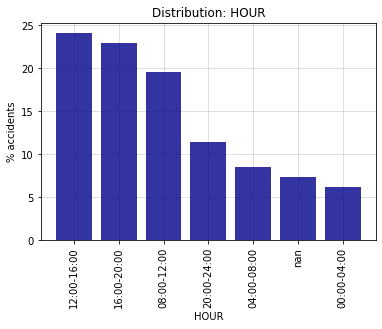

SPD_LIM,%
50,34.811075
NaN,30.546249
<50,17.751772
70,11.067043
100,4.783911
60,0.616280
80,0.329679
90,0.093991


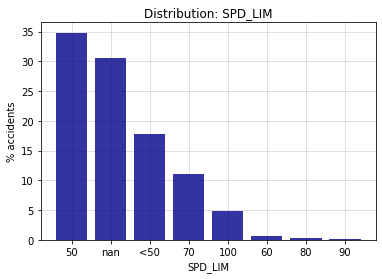

ACCDN_TYPE,%
veh,76.078667
fxd obj,9.085763
ped,4.417561
NaN,4.117075
cyc,2.838589
no coll,2.042873
oth,1.419472


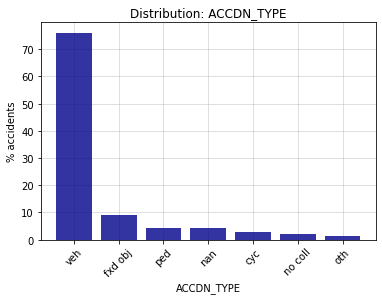

RD_COND,%
Dry,63.296651
Wet,16.702566
Snowy,8.787414
NaN,5.304419
Frozen,2.720388
Slush/sleet,1.492458
Hard snow,0.994734
Other,0.300485
Water acc,0.244589
Sand/gravel,0.113572


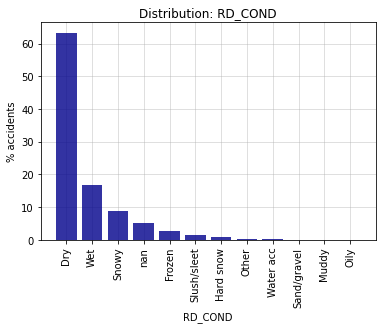

LIGHT,%
Clear day,63.404527
Lit path,25.589311
NaN,5.478160
Dawn/dusk,4.979368
Unlit path,0.548635


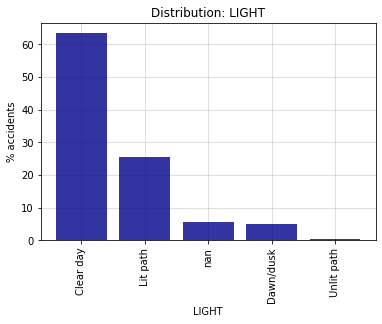

ZONE,%
Business/commercial,50.688375
Residential,34.416243
Industrial,6.407741
NaN,3.062885
Rural,2.232278
School,1.688984
Other,1.474300
Forest,0.029194


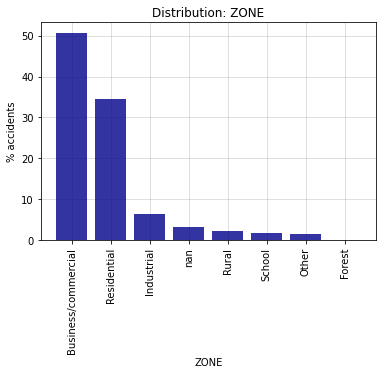

PUB_PRIV_RD,%
Public,85.297228
Private,11.793691
NaN,2.909082


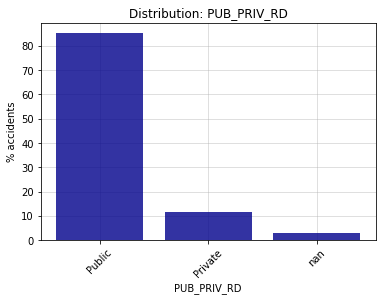

ASPECT,%
Straight,91.638392
NaN,4.255925
Curve,4.105683


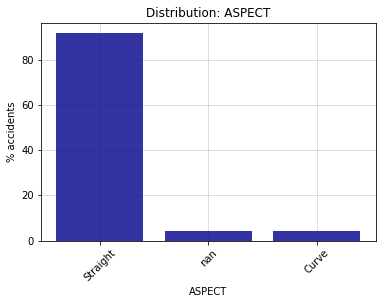

LONG_LOC,%
Int'n/roundabout,32.102080
Btwn int'ns,24.708860
Near int'n/roundabout,18.170458
Other,9.561057
NaN,7.911948
Shop centre,4.714130
Bridge etc.,2.831468


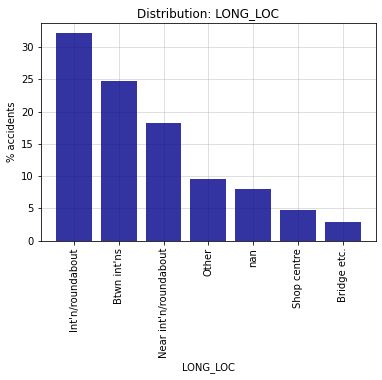

RD_CONFG,%
Two-way,43.309397
One-way,27.421416
Sep by layout,15.166317
NaN,9.149135
Other,4.953735


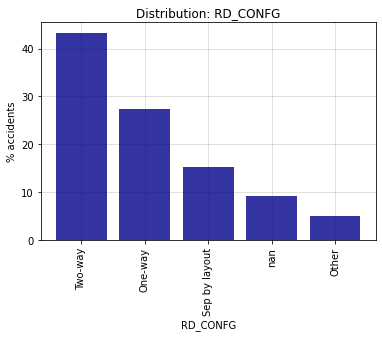

RDWX,%
NaN,96.491728
Y,3.508272


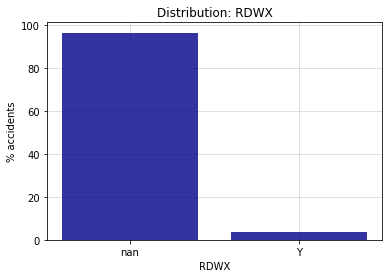

WEATHER,%
Clear,63.736698
Overcast,15.495284
Rain/drizzle,7.094514
NaN,5.674686
Snow/hail,5.387729
Blowing snow/snowstorm,0.844136
Downpour,0.608091
Other,0.486686
Black ice,0.326475
Strong wind,0.189049


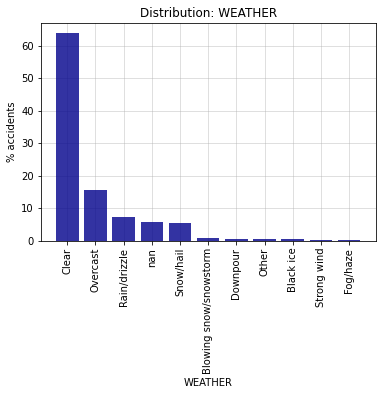

COLUMNS WITH NO NULL VALUES


YEAR,%
2011,12.209884
2012,11.140028
2013,11.073452
2017,8.344518
2018,8.207805
2016,8.164726
2015,8.121291
2014,8.029792
2019,7.543462
2022,6.252514


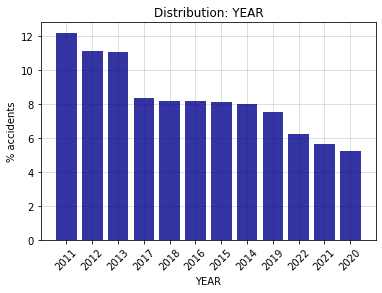

MONTH,%
Jan,9.521538
Feb,8.860755
Oct,8.694135
Dec,8.538908
Nov,8.493693
Jun,8.491557
Sep,8.475892
May,8.107050
Aug,8.100641
Jul,8.013059


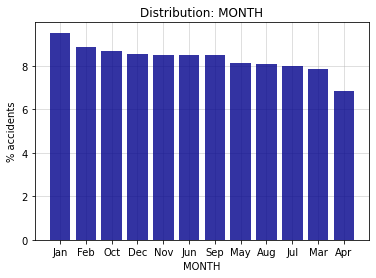

WKDY_WKND,%
WKDY,76.498065
WKND,23.501935


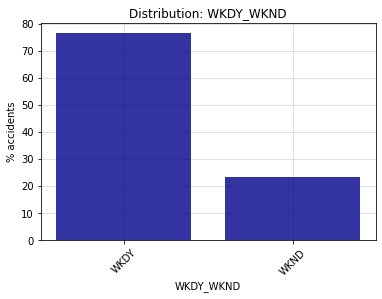

SEVERITY,%
Mat,43.529776
Mat < 2000,36.265794
Minor,19.343205
Fatal/serious,0.861225


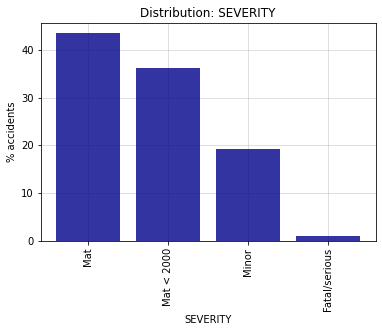

TNRY_SEV,%
Mat,79.795570
Minor,19.343205
Fatal/serious,0.861225


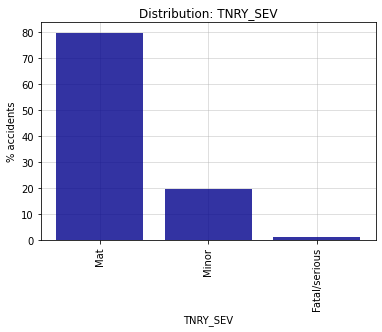

NUM_VICTIMS,%
0,79.795570
1,16.534166
2,2.761687
3+,0.908576


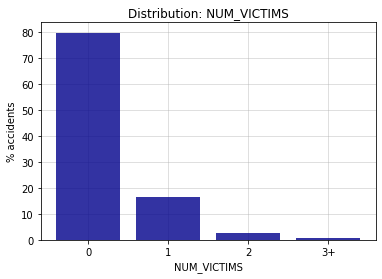

NUM_VEH,%
2,74.295693
1,16.323755
3+,9.380552


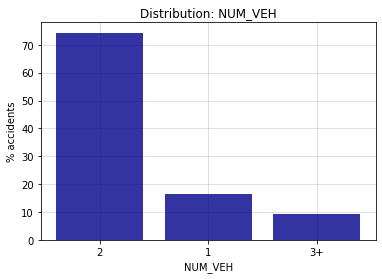

LT_TRK,%
Y,93.316695
N,6.683305


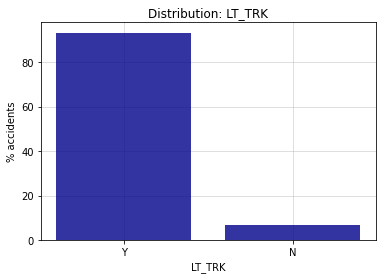

HVY_VEH,%
N,84.490475
Y,15.509525


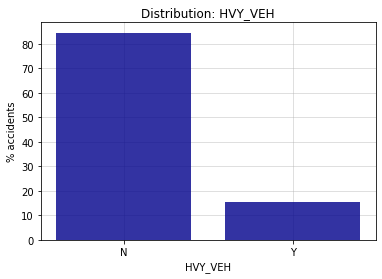

MTRCYC,%
N,98.214178
Y,1.785822


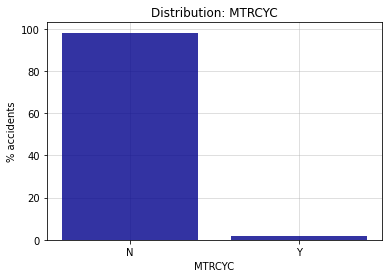

BICYC,%
N,96.896172
Y,3.103828


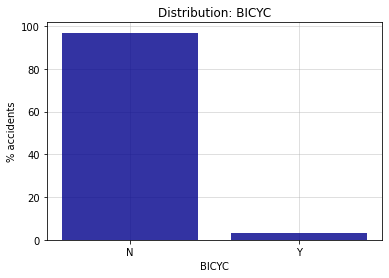

PED,%
N,96.027115
Y,3.972885


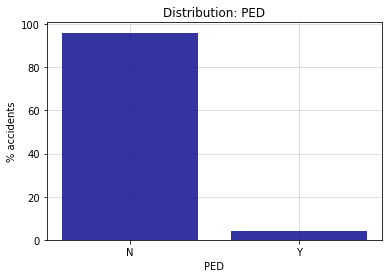

In [12]:
from exploration import distribution
from utils import get_variable_name

instance = mtl_3sev
df = instance.df_train

columns = [c for c in df if c not in ["ID"] + list(instance.restrict_to.keys())]
columns_with_nulls = df.columns[df.isnull().any()].tolist()
columns_without_nulls = [c for c in columns if c not in columns_with_nulls]

print("="*24 + "\nColumns with null values\n".upper() + "="*24)

for col in columns_with_nulls:
    distribution.table(df, col);
    filename = "_".join([get_variable_name(instance), "EDA", "bar", col]) + ".png"
    filepath = path["expository"].joinpath(filename)
    distribution.plot(df, col, save_as=filepath)
    
print("="*27 + "\nColumns with no null values\n".upper() + "="*27)

for col in columns_without_nulls:
    distribution.table(df, col);
    filename = "_".join([get_variable_name(instance), "EDA", "bar", col]) + ".png"
    filepath = path["expository"].joinpath(filename)
    distribution.plot(df, col, save_as=filepath)

TNRY_SEV,%
Mat,79.795570
Minor,19.343205
Fatal/serious,0.861225


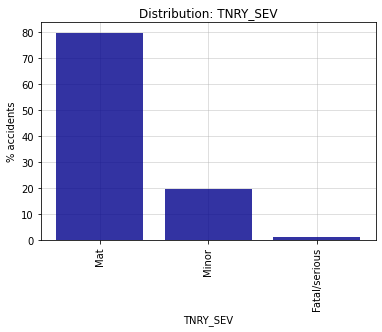

"(TNRY_SEV, NUM_VICTIMS)",%
"(Mat, 0)",79.795570
"(Minor, 1)",15.864483
"(Minor, 2)",2.634586
"(Minor, 3+)",0.844136
"(Fatal/serious, 1)",0.669683
"(Fatal/serious, 2)",0.127101
"(Fatal/serious, 3+)",0.064441


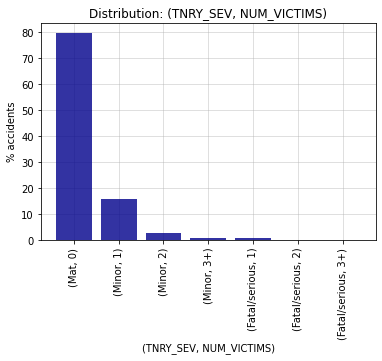

In [13]:
instance = mtl_3sev
df = instance.df_train

for target in instance.targets:
    distribution.table(df, target);
    filename = "_".join([get_variable_name(instance), "EDA", "bar", target]) + ".png"
    filepath = path["expository"].joinpath(filename)
    distribution.plot(df, target, save_as=filepath)

distribution.tuple_table(df, instance.targets + ["NUM_VICTIMS"]);
filename = "_".join([get_variable_name(instance), "EDA", "bar", "SEVERITY_NUM_VICTIMS"]) + ".png"
filepath = path["expository"].joinpath(filename)
distribution.tuple_plot(df, instance.targets + ["NUM_VICTIMS"], save_as=filepath)

<a id='relationshipscorrelations'></a>
## Relationships/correlations between variables
↑↑ [Contents](#contents) ↑ [Distribution of values for each variable](#distribution) ↓ [Heatmaps](#heatmaps)

As noted already in the case of ```NUM_VICTIMS``` and ```SEVERITY```/```TNRY_SEV```, certain variables may be closely (even logically) related. As another example, notice that we have the binary categorical variables ```PED``` and ```BICYC```, which indicate whether or not a pedestrian/cyclist is involved in the accident, while at the same time, ```ACCDN_TYPE``` includes ```pedestrian``` and ```cyclist``` as categories. It turns out _not_ to be the case that ```PED``` is ```Y``` implies ```ACCDN_TYPE``` is ```pedestrian```, nor vice-versa, and likewise ```BICYC = Y``` does (is) not imply (implied by) ```ACCDN_TYPE = cyclist```, but these statements are 'almost' true. (```ACCDN_TYPE``` refers to 'the nature of the accident and the **first physical event (impact)**', so, for instance, a pedestrian might be involved in an accident, but not as the first 'physical event'.)

On the other hand, notice that, if a pedestrian _is_ inolved in an accident, it can only be as a victim/injured person. Therefore, if ```PED``` is ```Y```, then ```NUM_VICTIMS``` and ```SEVERITY```/```TNRY_SEV``` is at least ```minor```. 

As these feature variables are categorical, we cannot directly measure 'correlations' between them and the target(s), but we can do the following.

In [16]:
from variables import class_codes
from saaq_data_dictionary import shorthand

instance = mtl_3sev
df = instance.df_train

variable_pairs = zip(["TNRY_SEV",
                       "PED", 
                       "BICYC", 
                       "PED",
                       "BICYC",
                       "NUM_VEH"],
                     ["NUM_VICTIMS",
                      "NUM_VICTIMS", 
                      "NUM_VICTIMS", 
                      "ACCDN_TYPE", 
                      "ACCDN_TYPE", 
                      "ACCDN_TYPE"])

for v1, v2 in variable_pairs:
    crosstab = pd.crosstab(df[v1], df[v2], dropna=False, margins=False)
    if v1 == "TNRY_SEV":
        order = class_codes["TNRY_SEV"].keys()
        crosstab = crosstab.loc[order]
    try:        
        crosstab.index = crosstab.index.map(shorthand[v1])
    except:
        pass
    try:
        crosstab.columns = crosstab.columns.map(shorthand[v2])
    except:
        pass
    display(crosstab)

NUM_VICTIMS,0,1,2,3+
TNRY_SEV,,,,
Mat,224129,0,0,0
Minor,0,44560,7400,2371
Fatal/serious,0,1881,357,181


NUM_VICTIMS,0,1,2,3+
PED,,,,
N,224129,35895,7236,2460
Y,0,10546,521,92


NUM_VICTIMS,0,1,2,3+
BICYC,,,,
N,222047,39934,7642,2538
Y,2082,6507,115,14


ACCDN_TYPE,cyc,fxd obj,no coll,oth,ped,veh
PED,,,,,,
N,7968,25455,5702,3970,1840,213245
Y,5,65,36,17,10568,444


ACCDN_TYPE,cyc,fxd obj,no coll,oth,ped,veh
BICYC,,,,,,
N,173,25495,5642,3968,12400,212981
Y,7800,25,96,19,8,708


ACCDN_TYPE,cyc,fxd obj,no coll,oth,ped,veh
NUM_VEH,,,,,,
1,43,23111,4528,2687,11904,2180
2,7725,2164,944,1157,472,186532
3+,205,245,266,143,32,24977


For the ordinal variables, we can look at correlations. There are no notable correlations, except for the obvious strong correlation (already noted) between number of victims and severity.

In [17]:
from variables import saaq_variable_types

instance = mtl_3sev
df = instance.df_train

ordinal_variables = [col for col in df.columns if saaq_variable_types[col] == "ordinal" and col != "SEVERITY"]

# print("Ordinal variables:", ", ".join(ordinal_variables))

df_ordinal = df[ordinal_variables].copy()
for col in df_ordinal:
    df_ordinal[col] = df_ordinal[col].map(class_codes[col])

display(df_ordinal.corr())

,TNRY_SEV,NUM_VICTIMS,NUM_VEH,SPD_LIM,LIGHT
TNRY_SEV,1.000000,0.887070,-0.100828,-0.027904,0.003126
NUM_VICTIMS,0.887070,1.000000,-0.028290,-0.007420,0.002943
NUM_VEH,-0.100828,-0.028290,1.000000,0.009109,0.078725
SPD_LIM,-0.027904,-0.007420,0.009109,1.000000,-0.006547
LIGHT,0.003126,0.002943,0.078725,-0.006547,1.000000


One might suspect a strong positive relationship between severity and whether or not an accident involves a pedestrian, cyclist, motorcyclist, etc. Let's take a look and see.

In [18]:
instance = mtl_3sev
df = instance.df_train

more_variable_pairs = [["TNRY_SEV", v] for v in ["ACCDN_TYPE",
                                                 "PED", 
                                                 "BICYC", 
                                                 "MTRCYC", 
                                                 "LT_TRK", 
                                                 "HVY_VEH",]]

for v1, v2 in more_variable_pairs:
    crosstab = pd.crosstab(df[v1], df[v2], 
                           dropna=False, margins=False, 
                           normalize="columns").mul(100).round(2)
    if v1 == "TNRY_SEV":
        order = class_codes["TNRY_SEV"].keys()
        crosstab = crosstab.loc[order]
        crosstab.index = crosstab.index.map(shorthand[v1])
    try:
        crosstab.columns = crosstab.columns.map(shorthand[v2])
    except:
        pass    
    display(crosstab)

ACCDN_TYPE,cyc,fxd obj,no coll,oth,ped,veh
TNRY_SEV,,,,,,
Mat,23.48,83.25,59.27,94.33,14.58,84.63
Minor,73.01,15.68,38.81,5.29,77.60,15.02
Fatal/serious,3.51,1.07,1.92,0.38,7.82,0.35


PED,N,Y
TNRY_SEV,,
Mat,83.10,0.00
Minor,16.39,90.73
Fatal/serious,0.51,9.27


BICYC,N,Y
TNRY_SEV,,
Mat,81.59,23.88
Minor,17.64,72.55
Fatal/serious,0.77,3.57


MTRCYC,N,Y
TNRY_SEV,,
Mat,80.50,40.83
Minor,18.71,54.15
Fatal/serious,0.79,5.02


LT_TRK,N,Y
TNRY_SEV,,
Mat,73.18,80.27
Minor,24.60,18.97
Fatal/serious,2.23,0.76


HVY_VEH,N,Y
TNRY_SEV,,
Mat,78.58,86.44
Minor,20.56,12.69
Fatal/serious,0.86,0.87


<a id='heatmaps'></a>
## Heatmaps
↑↑ [Contents](#contents) ↑ [Relationships/correlations between variables](#relationshipscorrelations) ↓ [Conditional distributions, with plots](#conditional)

For something visual, we can plot heatmaps...

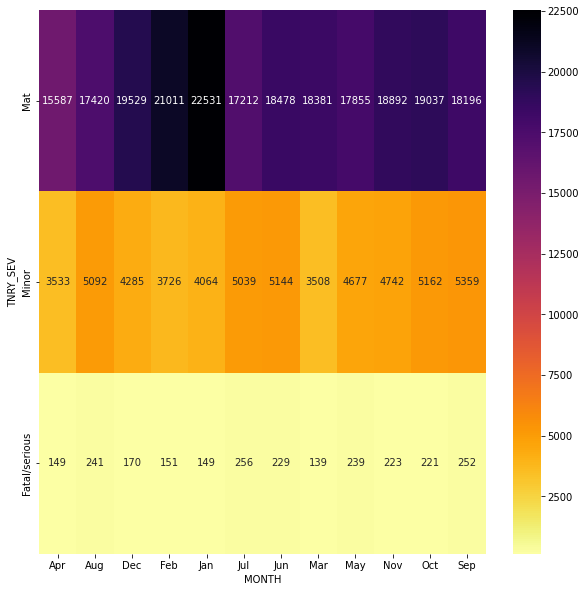

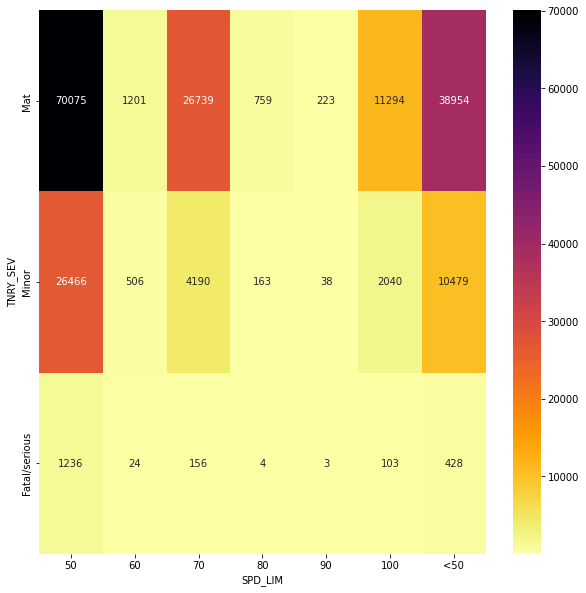

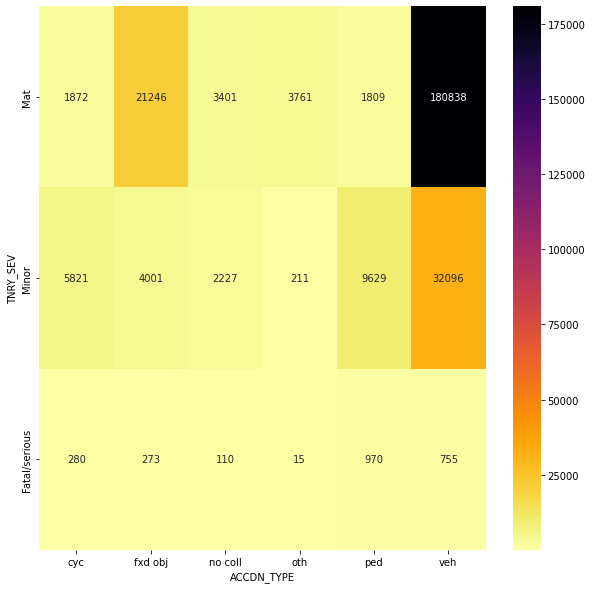

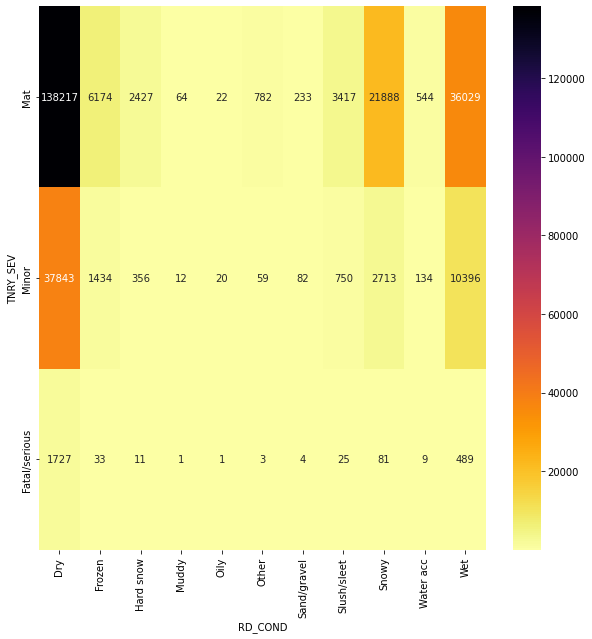

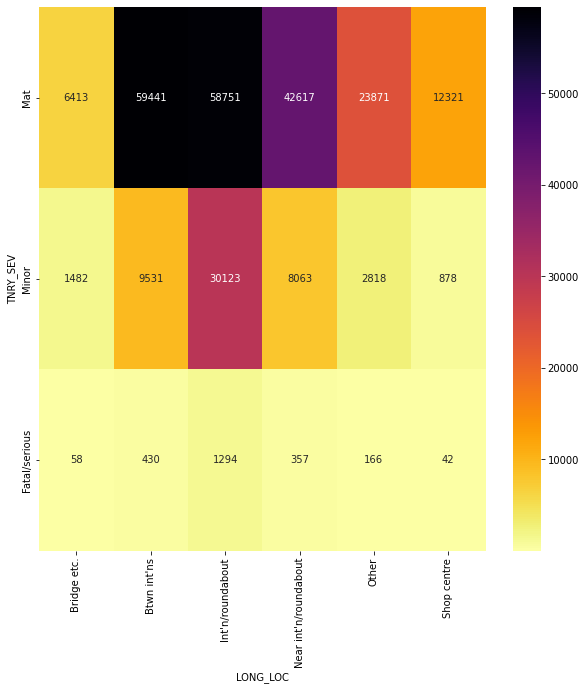

In [19]:
from matplotlib import pyplot as plt
import seaborn as sns

instance = mtl_3sev
df = instance.df_train.copy()

for col in df.columns:
    try:
        df[col] = df[col].map(shorthand[col])
    except:
        pass

columns = [c for c in df.columns if c not in instance.targets + ["SEVERITY"]]
columns.remove("ID")

# i columns[i]
# 0 'YEAR'
# 1 'MONTH'
# 2 'HOUR'
# 3 'WKDY_WKND'
# 4 'NUM_VICTIMS'
# 5 'NUM_VEH'
# 6 'REGION'
# 7 'SPD_LIM'
# 8 'ACCDN_TYPE'
# 9 'RD_COND'
# 10 'LIGHT'
# 11 'ZONE'
# 12 'PUB_PRIV_RD'
# 13 'ASPECT'
# 14 'LONG_LOC'
# 15 'RD_CONFG'
# 16 'RDWX'
# 17 'WEATHER'
# 18 'LT_TRK'
# 19 'HVY_VEH'
# 20 'MTRCYC'
# 21 'BICYC'
# 22 'PED'

for A in instance.targets:
    for idx in [1,7,8,9,14]:
        B = columns[idx]  
        AxB = pd.crosstab(df[A], df[B], dropna=True, margins=False)
        try:
            order = shorthand[A].values()
            AxB = AxB.loc[order]
        except:
            pass
        plt.figure(figsize=(10, 10))
        sns.heatmap(AxB, cmap='inferno_r', annot=True, fmt='d')
        filename = "_".join([get_variable_name(instance), "EDA", "heatmap", f"{A}", "by", f"{B}"]) + ".png"                
        filepath = path["expository"].joinpath(filename)
        plt.savefig(filepath)       

In [20]:
# Save on memory...
plt.close('all)')

<a id='conditional'></a>
## Conditional distributions, with plots
↑↑ [Contents](#contents) ↑ [Heatmaps](#heatmaps) ↓ [Animated plots](#animated_plots)

We can look at the probability distribution of the severity level of an accident _given_ a value of a patricular variable. We use our ```custom_crosstab``` and ```crosstab_plot``` (from our custom ```exploration``` module) to investigate and visualize these distributions. 

TNRY_SEV BY YEAR: Prob(TNRY_SEV | YEAR = column heading)


YEAR,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,All
Mat,28684 (↓83.64%),26079 (↓83.35%),26094 (↓83.9%),17661 (↓78.31%),17791 (↓77.99%),17780 (↓77.53%),18427 (↓78.62%),18273 (↓79.26%),16589 (↓78.29%),11630 (↓78.82%),11878 (↓74.72%),13243 (↓75.41%),224129 (↓79.8%)
Minor,5335 (↓15.56%),4951 (↓15.82%),4777 (↓15.36%),4653 (↓20.63%),4790 (↓21.0%),4956 (↓21.61%),4819 (↓20.56%),4587 (↓19.9%),4449 (↓21.0%),2970 (↓20.13%),3888 (↓24.46%),4156 (↓23.66%),54331 (↓19.34%)
Fatal/serious,276 (↓0.8%),260 (↓0.83%),232 (↓0.75%),240 (↓1.06%),230 (↓1.01%),197 (↓0.86%),192 (↓0.82%),194 (↓0.84%),150 (↓0.71%),155 (↓1.05%),130 (↓0.82%),163 (↓0.93%),2419 (↓0.86%)
All,34295 (↓100.0%),31290 (↓100.0%),31103 (↓100.0%),22554 (↓100.0%),22811 (↓100.0%),22933 (↓100.0%),23438 (↓100.0%),23054 (↓100.0%),21188 (↓100.0%),14755 (↓100.0%),15896 (↓100.0%),17562 (↓100.0%),280879 (↓100.0%)


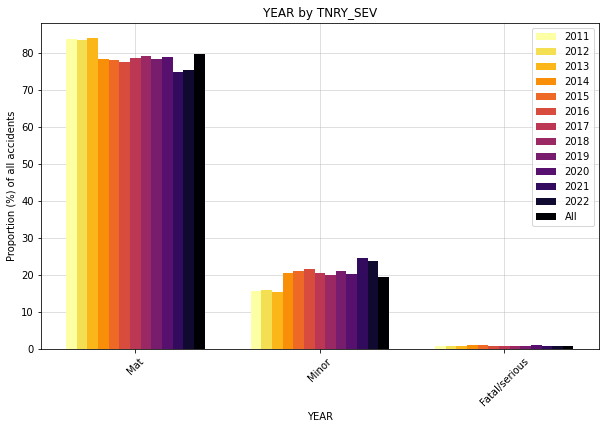

TNRY_SEV BY MONTH: Prob(TNRY_SEV | MONTH = column heading)


MONTH,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,All
Mat,15587 (↓80.89%),17420 (↓76.56%),19529 (↓81.43%),21011 (↓84.42%),22531 (↓84.25%),17212 (↓76.47%),18478 (↓77.47%),18381 (↓83.44%),17855 (↓78.41%),18892 (↓79.19%),19037 (↓77.96%),18196 (↓76.43%),224129 (↓79.8%)
Minor,3533 (↓18.34%),5092 (↓22.38%),4285 (↓17.87%),3726 (↓14.97%),4064 (↓15.2%),5039 (↓22.39%),5144 (↓21.57%),3508 (↓15.93%),4677 (↓20.54%),4742 (↓19.88%),5162 (↓21.14%),5359 (↓22.51%),54331 (↓19.34%)
Fatal/serious,149 (↓0.77%),241 (↓1.06%),170 (↓0.71%),151 (↓0.61%),149 (↓0.56%),256 (↓1.14%),229 (↓0.96%),139 (↓0.63%),239 (↓1.05%),223 (↓0.93%),221 (↓0.9%),252 (↓1.06%),2419 (↓0.86%)
All,19269 (↓100.0%),22753 (↓100.0%),23984 (↓100.0%),24888 (↓100.0%),26744 (↓100.0%),22507 (↓100.0%),23851 (↓100.0%),22028 (↓100.0%),22771 (↓100.0%),23857 (↓100.0%),24420 (↓100.0%),23807 (↓100.0%),280879 (↓100.0%)


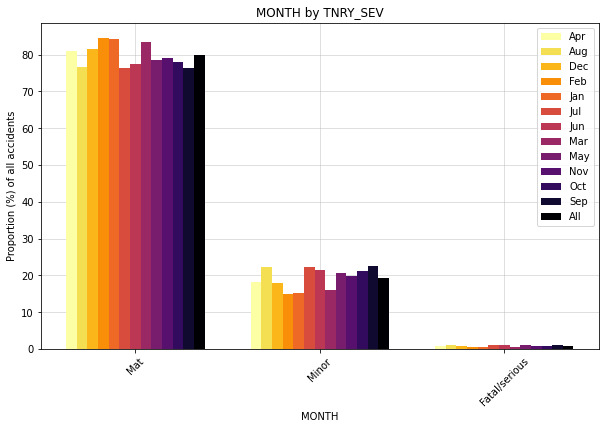

TNRY_SEV BY HOUR: Prob(TNRY_SEV | HOUR = column heading)


HOUR,00:00-04:00,04:00-08:00,08:00-12:00,12:00-16:00,16:00-20:00,20:00-24:00,All
Mat,14224 (↓81.56%),18657 (↓78.2%),43921 (↓80.11%),53007 (↓78.39%),49243 (↓76.39%),25365 (↓78.78%),204417 (↓78.5%)
Minor,2913 (↓16.7%),4937 (↓20.69%),10538 (↓19.22%),14105 (↓20.86%),14695 (↓22.8%),6425 (↓19.95%),53613 (↓20.59%)
Fatal/serious,303 (↓1.74%),264 (↓1.11%),366 (↓0.67%),509 (↓0.75%),522 (↓0.81%),408 (↓1.27%),2372 (↓0.91%)
All,17440 (↓100.0%),23858 (↓100.0%),54825 (↓100.0%),67621 (↓100.0%),64460 (↓100.0%),32198 (↓100.0%),260402 (↓100.0%)


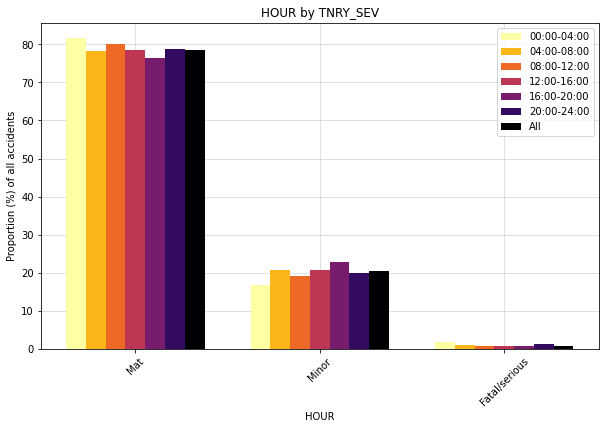

TNRY_SEV BY WKDY_WKND: Prob(TNRY_SEV | WKDY_WKND = column heading)


WKDY_WKND,WKDY,WKND,All
Mat,171300 (↓79.72%),52829 (↓80.03%),224129 (↓79.8%)
Minor,41824 (↓19.47%),12507 (↓18.95%),54331 (↓19.34%)
Fatal/serious,1743 (↓0.81%),676 (↓1.02%),2419 (↓0.86%)
All,214867 (↓100.0%),66012 (↓100.0%),280879 (↓100.0%)


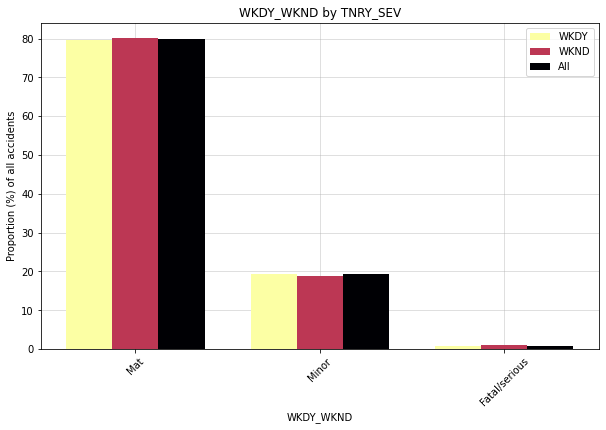

TNRY_SEV BY SEVERITY: Prob(TNRY_SEV | SEVERITY = column heading)


SEVERITY,Fatal/serious,Mat,Mat < 2000,Minor,All
Mat,0 (↓0.0%),122266 (↓100.0%),101863 (↓100.0%),0 (↓0.0%),224129 (↓79.8%)
Minor,0 (↓0.0%),0 (↓0.0%),0 (↓0.0%),54331 (↓100.0%),54331 (↓19.34%)
Fatal/serious,2419 (↓100.0%),0 (↓0.0%),0 (↓0.0%),0 (↓0.0%),2419 (↓0.86%)
All,2419 (↓100.0%),122266 (↓100.0%),101863 (↓100.0%),54331 (↓100.0%),280879 (↓100.0%)


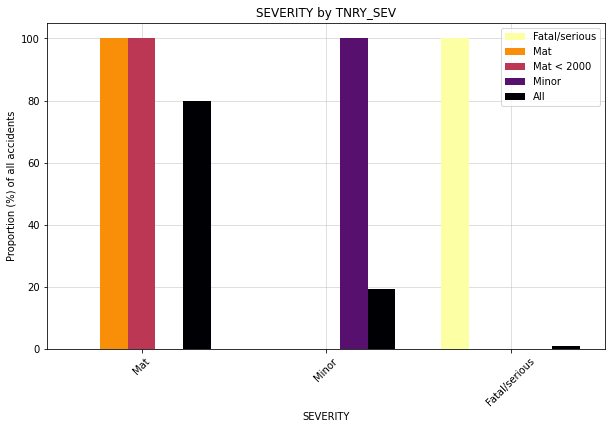

TNRY_SEV BY NUM_VICTIMS: Prob(TNRY_SEV | NUM_VICTIMS = column heading)


NUM_VICTIMS,0,1,2,3+,All
Mat,224129 (↓100.0%),0 (↓0.0%),0 (↓0.0%),0 (↓0.0%),224129 (↓79.8%)
Minor,0 (↓0.0%),44560 (↓95.95%),7400 (↓95.4%),2371 (↓92.91%),54331 (↓19.34%)
Fatal/serious,0 (↓0.0%),1881 (↓4.05%),357 (↓4.6%),181 (↓7.09%),2419 (↓0.86%)
All,224129 (↓100.0%),46441 (↓100.0%),7757 (↓100.0%),2552 (↓100.0%),280879 (↓100.0%)


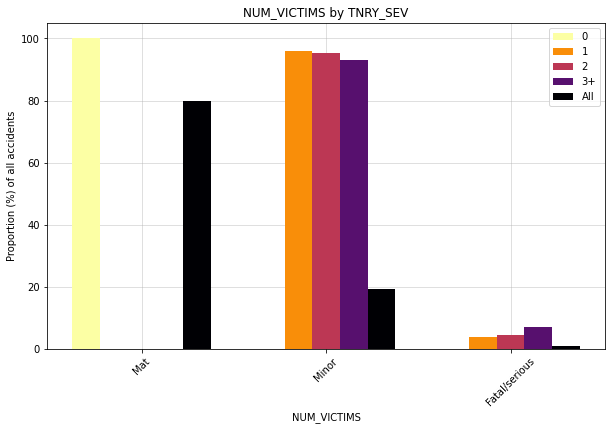

TNRY_SEV BY NUM_VEH: Prob(TNRY_SEV | NUM_VEH = column heading)


NUM_VEH,1,2,3+,All
Mat,29227 (↓63.74%),176009 (↓84.34%),18893 (↓71.71%),224129 (↓79.8%)
Minor,15350 (↓33.48%),31766 (↓15.22%),7215 (↓27.38%),54331 (↓19.34%)
Fatal/serious,1273 (↓2.78%),906 (↓0.43%),240 (↓0.91%),2419 (↓0.86%)
All,45850 (↓100.0%),208681 (↓100.0%),26348 (↓100.0%),280879 (↓100.0%)


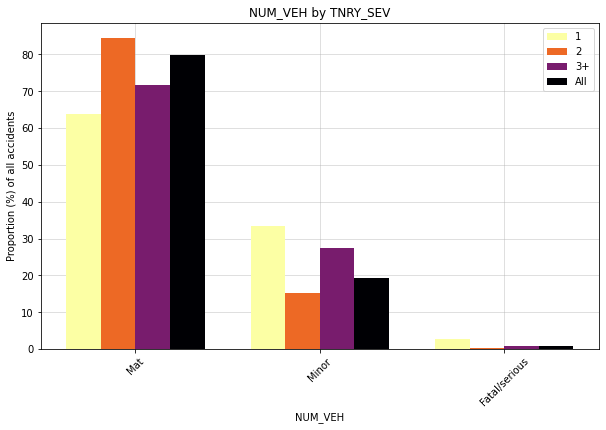

TNRY_SEV BY REGION: Prob(TNRY_SEV | REGION = column heading)


REGION,Montréal,All
Mat,224129 (↓79.8%),224129 (↓79.8%)
Minor,54331 (↓19.34%),54331 (↓19.34%)
Fatal/serious,2419 (↓0.86%),2419 (↓0.86%)
All,280879 (↓100.0%),280879 (↓100.0%)


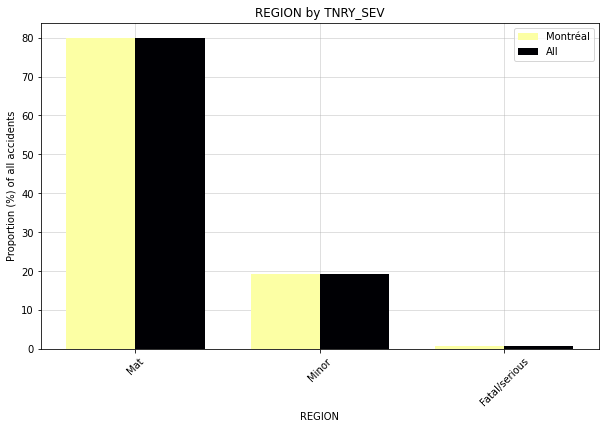

TNRY_SEV BY SPD_LIM: Prob(TNRY_SEV | SPD_LIM = column heading)


SPD_LIM,50,60,70,80,90,100,<50,All
Mat,70075 (↓71.67%),1201 (↓69.38%),26739 (↓86.02%),759 (↓81.97%),223 (↓84.47%),11294 (↓84.05%),38954 (↓78.13%),149245 (↓76.5%)
Minor,26466 (↓27.07%),506 (↓29.23%),4190 (↓13.48%),163 (↓17.6%),38 (↓14.39%),2040 (↓15.18%),10479 (↓21.02%),43882 (↓22.49%)
Fatal/serious,1236 (↓1.26%),24 (↓1.39%),156 (↓0.5%),4 (↓0.43%),3 (↓1.14%),103 (↓0.77%),428 (↓0.86%),1954 (↓1.0%)
All,97777 (↓100.0%),1731 (↓100.0%),31085 (↓100.0%),926 (↓100.0%),264 (↓100.0%),13437 (↓100.0%),49861 (↓100.0%),195081 (↓100.0%)


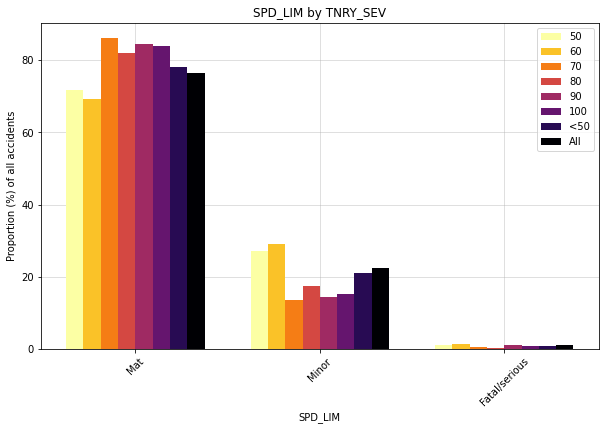

TNRY_SEV BY ACCDN_TYPE: Prob(TNRY_SEV | ACCDN_TYPE = column heading)


ACCDN_TYPE,cyc,fxd obj,no coll,oth,ped,veh,All
Mat,1872 (↓23.48%),21246 (↓83.25%),3401 (↓59.27%),3761 (↓94.33%),1809 (↓14.58%),180838 (↓84.63%),212927 (↓79.06%)
Minor,5821 (↓73.01%),4001 (↓15.68%),2227 (↓38.81%),211 (↓5.29%),9629 (↓77.6%),32096 (↓15.02%),53985 (↓20.05%)
Fatal/serious,280 (↓3.51%),273 (↓1.07%),110 (↓1.92%),15 (↓0.38%),970 (↓7.82%),755 (↓0.35%),2403 (↓0.89%)
All,7973 (↓100.0%),25520 (↓100.0%),5738 (↓100.0%),3987 (↓100.0%),12408 (↓100.0%),213689 (↓100.0%),269315 (↓100.0%)


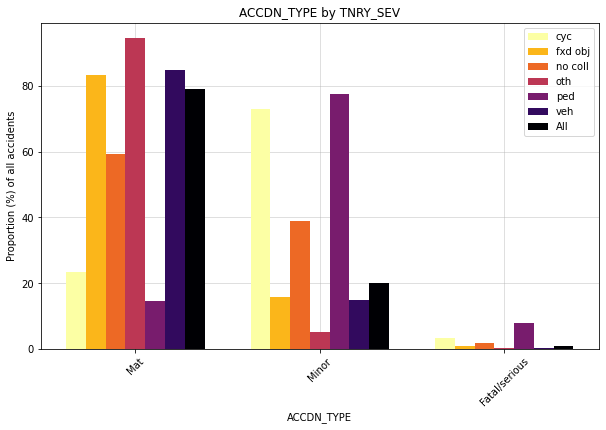

TNRY_SEV BY RD_COND: Prob(TNRY_SEV | RD_COND = column heading)


RD_COND,Dry,Frozen,Hard snow,Muddy,Oily,Other,Sand/gravel,Slush/sleet,Snowy,Water acc,Wet,All
Mat,138217 (↓77.74%),6174 (↓80.8%),2427 (↓86.86%),64 (↓83.12%),22 (↓51.16%),782 (↓92.65%),233 (↓73.04%),3417 (↓81.51%),21888 (↓88.68%),544 (↓79.18%),36029 (↓76.8%),209797 (↓78.88%)
Minor,37843 (↓21.29%),1434 (↓18.77%),356 (↓12.74%),12 (↓15.58%),20 (↓46.51%),59 (↓6.99%),82 (↓25.71%),750 (↓17.89%),2713 (↓10.99%),134 (↓19.51%),10396 (↓22.16%),53799 (↓20.23%)
Fatal/serious,1727 (↓0.97%),33 (↓0.43%),11 (↓0.39%),1 (↓1.3%),1 (↓2.33%),3 (↓0.36%),4 (↓1.25%),25 (↓0.6%),81 (↓0.33%),9 (↓1.31%),489 (↓1.04%),2384 (↓0.9%)
All,177787 (↓100.0%),7641 (↓100.0%),2794 (↓100.0%),77 (↓100.0%),43 (↓100.0%),844 (↓100.0%),319 (↓100.0%),4192 (↓100.0%),24682 (↓100.0%),687 (↓100.0%),46914 (↓100.0%),265980 (↓100.0%)


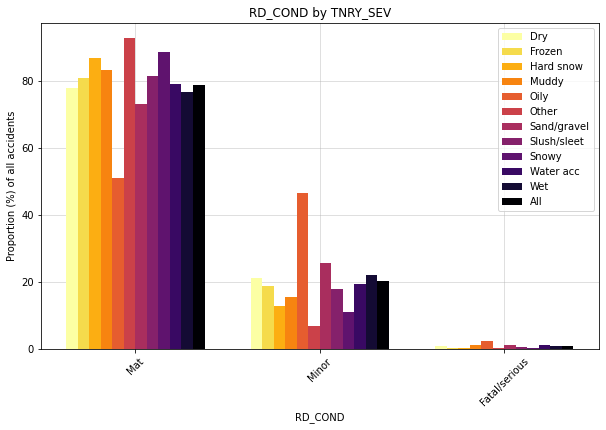

TNRY_SEV BY LIGHT: Prob(TNRY_SEV | LIGHT = column heading)


LIGHT,Clear day,Dawn/dusk,Lit path,Unlit path,All
Mat,139819 (↓78.51%),11182 (↓79.95%),56933 (↓79.21%),1280 (↓83.06%),209214 (↓78.8%)
Minor,36965 (↓20.76%),2681 (↓19.17%),14014 (↓19.5%),227 (↓14.73%),53887 (↓20.3%)
Fatal/serious,1306 (↓0.73%),123 (↓0.88%),928 (↓1.29%),34 (↓2.21%),2391 (↓0.9%)
All,178090 (↓100.0%),13986 (↓100.0%),71875 (↓100.0%),1541 (↓100.0%),265492 (↓100.0%)


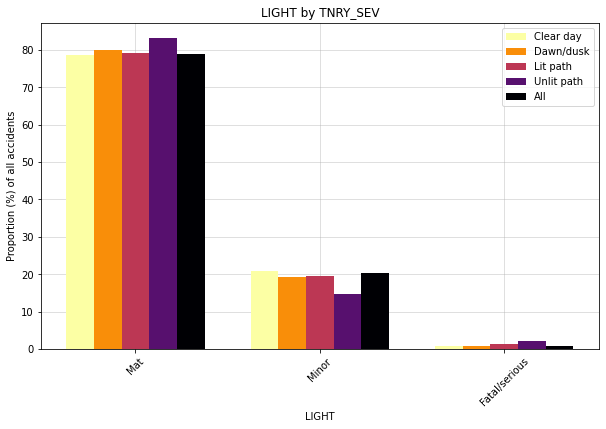

TNRY_SEV BY ZONE: Prob(TNRY_SEV | ZONE = column heading)


ZONE,Business/commercial,Forest,Industrial,Other,Residential,Rural,School,All
Mat,113444 (↓79.68%),66 (↓80.49%),14374 (↓79.86%),3310 (↓79.93%),76167 (↓78.79%),5242 (↓83.6%),3557 (↓74.98%),216160 (↓79.39%)
Minor,27733 (↓19.48%),15 (↓18.29%),3446 (↓19.15%),768 (↓18.55%),19644 (↓20.32%),977 (↓15.58%),1144 (↓24.11%),53727 (↓19.73%)
Fatal/serious,1196 (↓0.84%),1 (↓1.22%),178 (↓0.99%),63 (↓1.52%),857 (↓0.89%),51 (↓0.81%),43 (↓0.91%),2389 (↓0.88%)
All,142373 (↓100.0%),82 (↓100.0%),17998 (↓100.0%),4141 (↓100.0%),96668 (↓100.0%),6270 (↓100.0%),4744 (↓100.0%),272276 (↓100.0%)


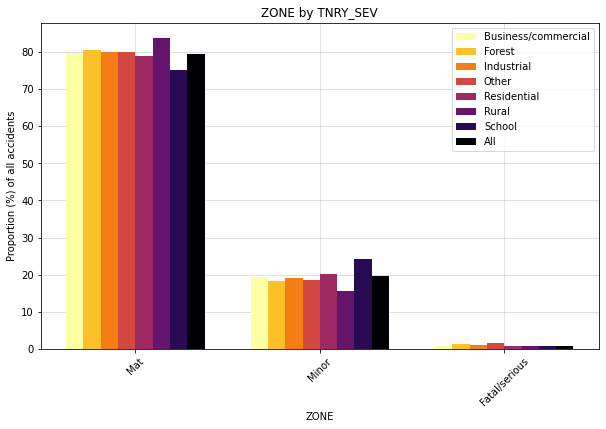

TNRY_SEV BY PUB_PRIV_RD: Prob(TNRY_SEV | PUB_PRIV_RD = column heading)


PUB_PRIV_RD,Private,Public,All
Mat,31092 (↓93.86%),185459 (↓77.41%),216551 (↓79.41%)
Minor,1917 (↓5.79%),51851 (↓21.64%),53768 (↓19.72%)
Fatal/serious,117 (↓0.35%),2272 (↓0.95%),2389 (↓0.88%)
All,33126 (↓100.0%),239582 (↓100.0%),272708 (↓100.0%)


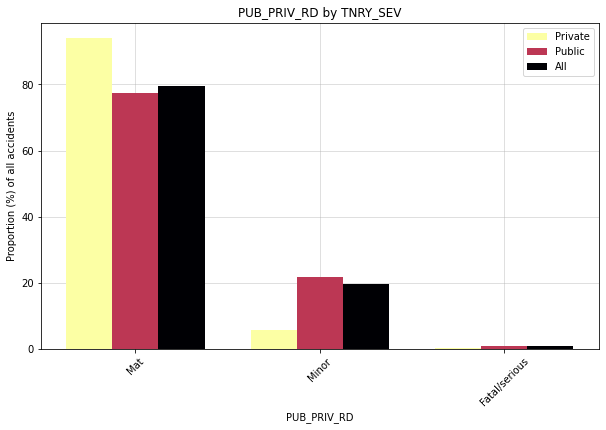

TNRY_SEV BY ASPECT: Prob(TNRY_SEV | ASPECT = column heading)


ASPECT,Curve,Straight,All
Mat,9309 (↓80.72%),203382 (↓79.02%),212691 (↓79.09%)
Minor,2073 (↓17.98%),51771 (↓20.11%),53844 (↓20.02%)
Fatal/serious,150 (↓1.3%),2240 (↓0.87%),2390 (↓0.89%)
All,11532 (↓100.0%),257393 (↓100.0%),268925 (↓100.0%)


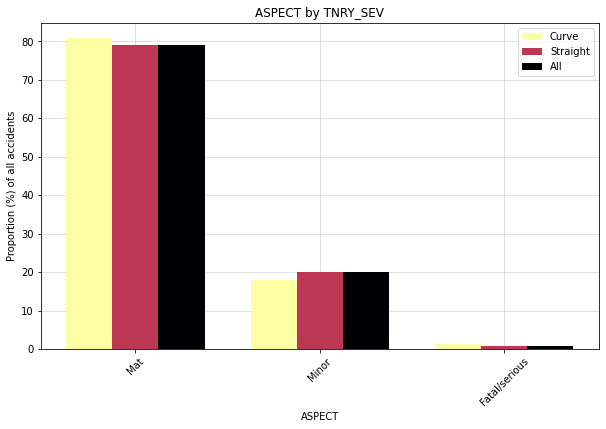

TNRY_SEV BY LONG_LOC: Prob(TNRY_SEV | LONG_LOC = column heading)


LONG_LOC,Bridge etc.,Btwn int'ns,Int'n/roundabout,Near int'n/roundabout,Other,Shop centre,All
Mat,6413 (↓80.64%),59441 (↓85.65%),58751 (↓65.16%),42617 (↓83.5%),23871 (↓88.89%),12321 (↓93.05%),203414 (↓78.64%)
Minor,1482 (↓18.63%),9531 (↓13.73%),30123 (↓33.41%),8063 (↓15.8%),2818 (↓10.49%),878 (↓6.63%),52895 (↓20.45%)
Fatal/serious,58 (↓0.73%),430 (↓0.62%),1294 (↓1.44%),357 (↓0.7%),166 (↓0.62%),42 (↓0.32%),2347 (↓0.91%)
All,7953 (↓100.0%),69402 (↓100.0%),90168 (↓100.0%),51037 (↓100.0%),26855 (↓100.0%),13241 (↓100.0%),258656 (↓100.0%)


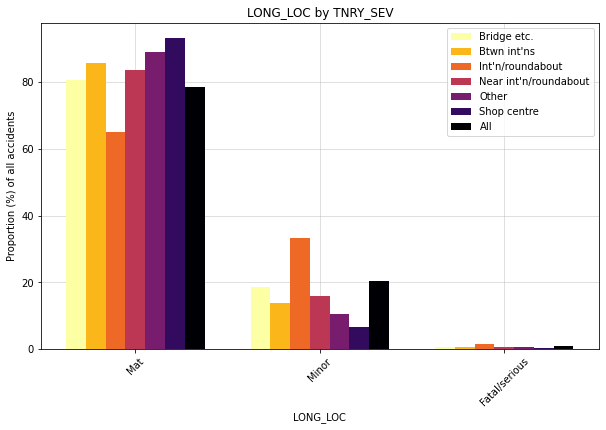

TNRY_SEV BY RD_CONFG: Prob(TNRY_SEV | RD_CONFG = column heading)


RD_CONFG,One-way,Other,Sep by layout,Two-way,All
Mat,64785 (↓84.11%),12784 (↓91.88%),33625 (↓78.93%),88646 (↓72.87%),199840 (↓78.31%)
Minor,11756 (↓15.26%),1058 (↓7.6%),8581 (↓20.14%),31599 (↓25.98%),52994 (↓20.77%)
Fatal/serious,480 (↓0.62%),72 (↓0.52%),393 (↓0.92%),1402 (↓1.15%),2347 (↓0.92%)
All,77021 (↓100.0%),13914 (↓100.0%),42599 (↓100.0%),121647 (↓100.0%),255181 (↓100.0%)


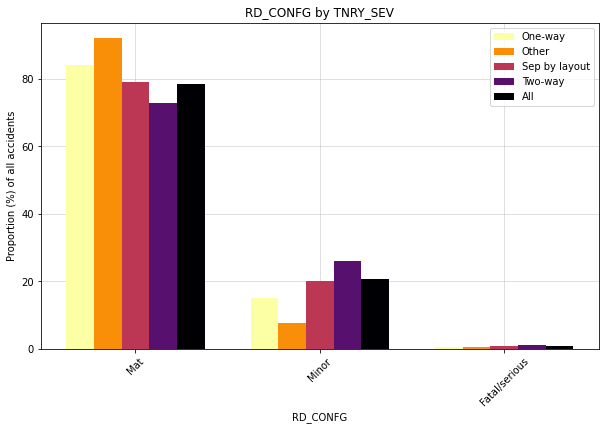

TNRY_SEV BY RDWX: Prob(TNRY_SEV | RDWX = column heading)


RDWX,Y,All
Mat,7824 (↓79.4%),7824 (↓79.4%)
Minor,1939 (↓19.68%),1939 (↓19.68%)
Fatal/serious,91 (↓0.92%),91 (↓0.92%)
All,9854 (↓100.0%),9854 (↓100.0%)


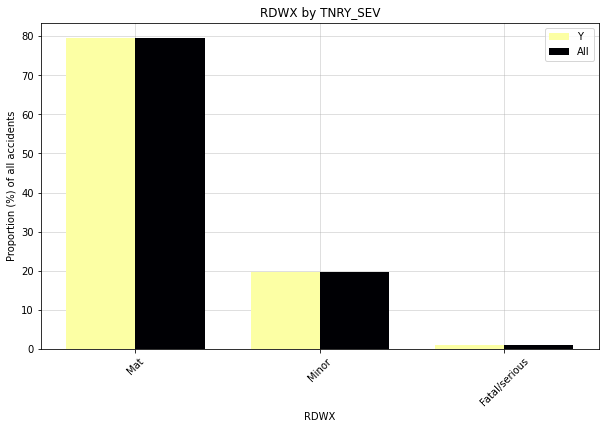

TNRY_SEV BY WEATHER: Prob(TNRY_SEV | WEATHER = column heading)


WEATHER,Black ice,Blowing snow/snowstorm,Clear,Downpour,Fog/haze,Other,Overcast,Rain/drizzle,Snow/hail,Strong wind,All
Mat,774 (↓84.41%),2024 (↓85.36%),139980 (↓78.19%),1182 (↓69.2%),355 (↓80.68%),1292 (↓94.51%),34927 (↓80.25%),14912 (↓74.83%),12923 (↓85.4%),427 (↓80.41%),208796 (↓78.81%)
Minor,140 (↓15.27%),332 (↓14.0%),37369 (↓20.87%),498 (↓29.16%),83 (↓18.86%),72 (↓5.27%),8231 (↓18.91%),4793 (↓24.05%),2148 (↓14.19%),95 (↓17.89%),53761 (↓20.29%)
Fatal/serious,3 (↓0.33%),15 (↓0.63%),1674 (↓0.94%),28 (↓1.64%),2 (↓0.45%),3 (↓0.22%),365 (↓0.84%),222 (↓1.11%),62 (↓0.41%),9 (↓1.69%),2383 (↓0.9%)
All,917 (↓100.0%),2371 (↓100.0%),179023 (↓100.0%),1708 (↓100.0%),440 (↓100.0%),1367 (↓100.0%),43523 (↓100.0%),19927 (↓100.0%),15133 (↓100.0%),531 (↓100.0%),264940 (↓100.0%)


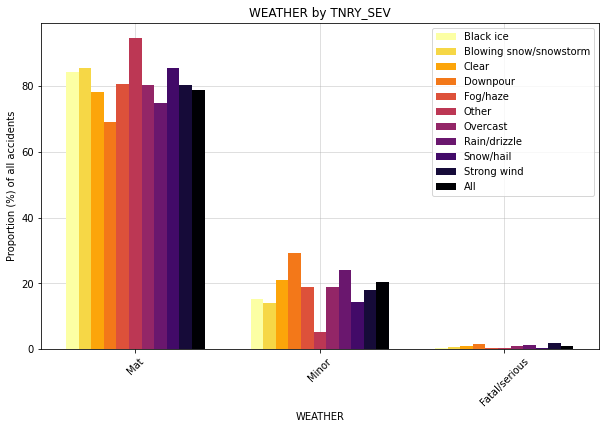

TNRY_SEV BY LT_TRK: Prob(TNRY_SEV | LT_TRK = column heading)


LT_TRK,N,Y,All
Mat,13737 (↓73.18%),210392 (↓80.27%),224129 (↓79.8%)
Minor,4617 (↓24.6%),49714 (↓18.97%),54331 (↓19.34%)
Fatal/serious,418 (↓2.23%),2001 (↓0.76%),2419 (↓0.86%)
All,18772 (↓100.0%),262107 (↓100.0%),280879 (↓100.0%)


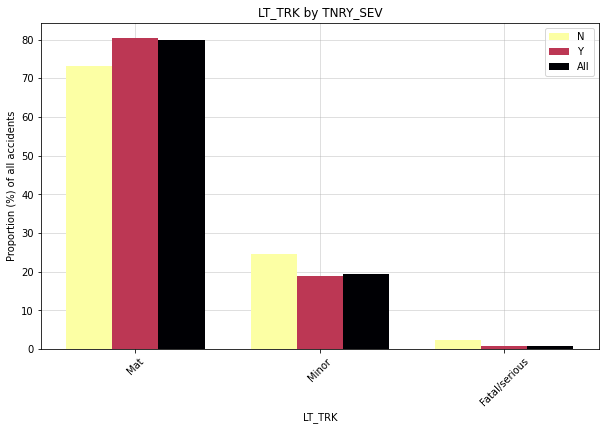

TNRY_SEV BY HVY_VEH: Prob(TNRY_SEV | HVY_VEH = column heading)


HVY_VEH,N,Y,All
Mat,186473 (↓78.58%),37656 (↓86.44%),224129 (↓79.8%)
Minor,48802 (↓20.56%),5529 (↓12.69%),54331 (↓19.34%)
Fatal/serious,2041 (↓0.86%),378 (↓0.87%),2419 (↓0.86%)
All,237316 (↓100.0%),43563 (↓100.0%),280879 (↓100.0%)


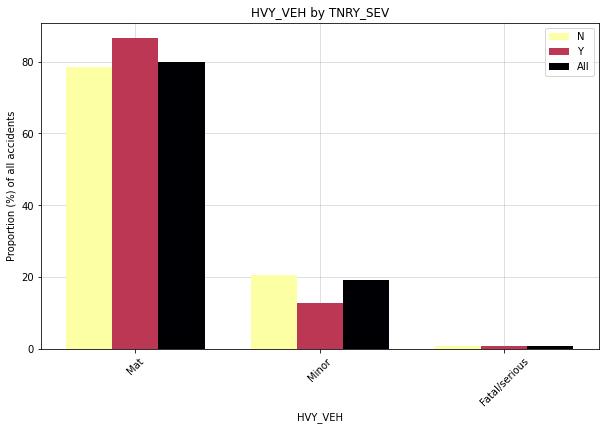

TNRY_SEV BY MTRCYC: Prob(TNRY_SEV | MTRCYC = column heading)


MTRCYC,N,Y,All
Mat,222081 (↓80.5%),2048 (↓40.83%),224129 (↓79.8%)
Minor,51615 (↓18.71%),2716 (↓54.15%),54331 (↓19.34%)
Fatal/serious,2167 (↓0.79%),252 (↓5.02%),2419 (↓0.86%)
All,275863 (↓100.0%),5016 (↓100.0%),280879 (↓100.0%)


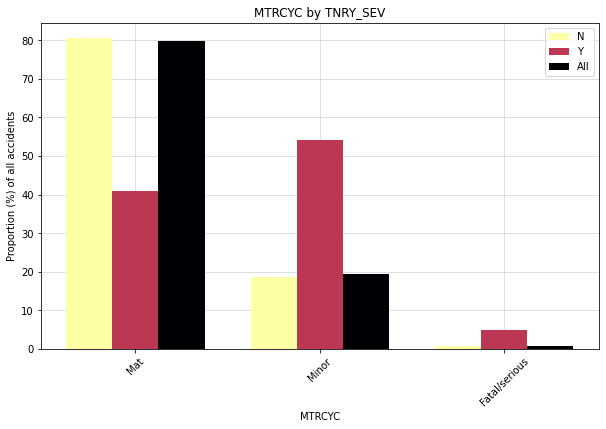

TNRY_SEV BY BICYC: Prob(TNRY_SEV | BICYC = column heading)


BICYC,N,Y,All
Mat,222047 (↓81.59%),2082 (↓23.88%),224129 (↓79.8%)
Minor,48006 (↓17.64%),6325 (↓72.55%),54331 (↓19.34%)
Fatal/serious,2108 (↓0.77%),311 (↓3.57%),2419 (↓0.86%)
All,272161 (↓100.0%),8718 (↓100.0%),280879 (↓100.0%)


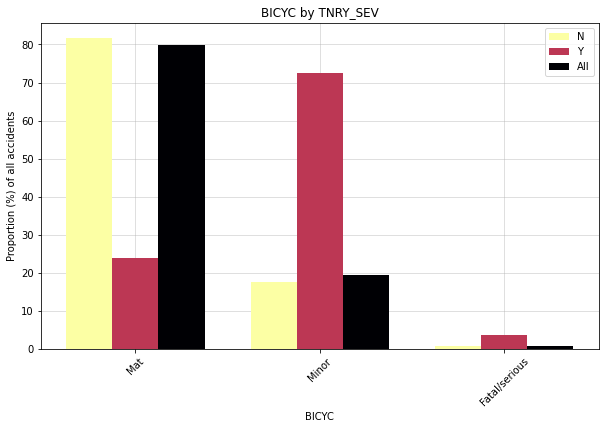

TNRY_SEV BY PED: Prob(TNRY_SEV | PED = column heading)


PED,N,Y,All
Mat,224129 (↓83.1%),0 (↓0.0%),224129 (↓79.8%)
Minor,44206 (↓16.39%),10125 (↓90.73%),54331 (↓19.34%)
Fatal/serious,1385 (↓0.51%),1034 (↓9.27%),2419 (↓0.86%)
All,269720 (↓100.0%),11159 (↓100.0%),280879 (↓100.0%)


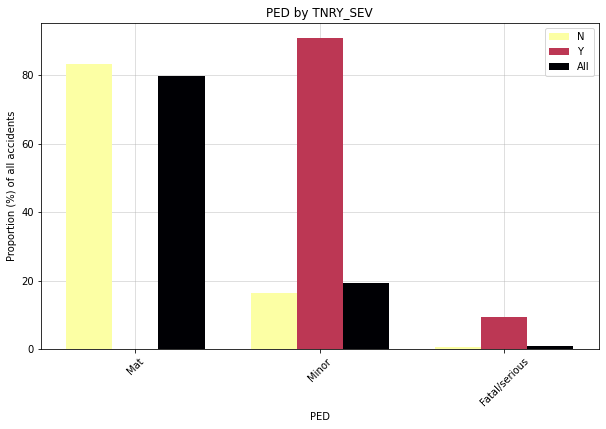

In [21]:
from saaq_data_dictionary import shorthand
from exploration import custom_crosstab, crosstab_plot

instance = mtl_3sev
df = instance.df_train.copy()

for col in df.columns:
    try:
        df[col] = df[col].map(shorthand[col])
    except:
        pass

columns = [c for c in df.columns if c not in instance.targets]
columns.remove("ID")

for A in instance.targets:
    for B in columns:
        print(f"{A} by {B}:".upper(), f"Prob({A} | {B} = column heading)")
        _, AxB1, AxB2, _, _ = custom_crosstab(df[A], df[B])  
        try:
            order = list(shorthand[A].values())
            AxB1 = AxB1.loc[order]
            order = order + ['All']
            AxB2 = AxB2.loc[order]
        except:
            pass
        display(AxB2)
        filename = "_".join([get_variable_name(instance), "EDA", "bar", f"{A}", "by", f"{B}"]) + ".png"                
        filepath = path["expository"].joinpath(filename)
        crosstab_plot(AxB1,ylabel=f"Proportion (%) of all accidents",save_as=filepath)

In [23]:
# Save memory...
plt.close('all')

<a id='animated_plots'></a>
## Animated plots
↑↑ [Contents](#contents) ↑ [Conditional distributions, with plots](#conditional) ↓ [Repeat with four-level severity](#repeat_with)

We can even show these distributions in an animated sequence, rather than in a single, static plot. For this, we call our ```crosstab_animation``` function from the ```exploration``` module.

SPD_LIM,50,60,70,80,90,100,<50,All
Mat,70075 (↓71.67%),1201 (↓69.38%),26739 (↓86.02%),759 (↓81.97%),223 (↓84.47%),11294 (↓84.05%),38954 (↓78.13%),149245 (↓76.5%)
Minor,26466 (↓27.07%),506 (↓29.23%),4190 (↓13.48%),163 (↓17.6%),38 (↓14.39%),2040 (↓15.18%),10479 (↓21.02%),43882 (↓22.49%)
Fatal/serious,1236 (↓1.26%),24 (↓1.39%),156 (↓0.5%),4 (↓0.43%),3 (↓1.14%),103 (↓0.77%),428 (↓0.86%),1954 (↓1.0%)
All,97777 (↓100.0%),1731 (↓100.0%),31085 (↓100.0%),926 (↓100.0%),264 (↓100.0%),13437 (↓100.0%),49861 (↓100.0%),195081 (↓100.0%)


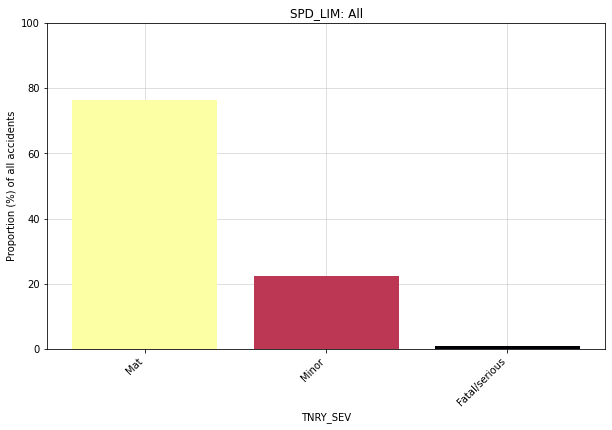

In [24]:
from saaq_data_dictionary import shorthand
from exploration import custom_crosstab, crosstab_animation
from IPython.display import HTML

instance = mtl_3sev
df = instance.df_train.copy()

A = "TNRY_SEV"
BB = ["MONTH", "ACCDN_TYPE", "WEATHER", "RD_CONFG", "RD_COND", "LONG_LOC", "ASPECT", "SPD_LIM"]
B = BB[7]

try:
    df[A] = df[A].map(shorthand[A])
except:
    pass

try:
    df[B] = df[B].map(shorthand[B])
except:
    pass

filename = filename = "_".join([get_variable_name(instance), "EDA", "crosstab", f"{A}", "by", f"{B}"]) + ".txt"
filepath = path["expository"].joinpath(filename)
AxB = custom_crosstab(df[A], df[B], save_as=None)[1]
AxB2 = custom_crosstab(df[A], df[B])[2]

try:
    order = list(shorthand[A].values())
    AxB = AxB.loc[order]
    order2 = order + ['All']
    AxB2 = AxB2.loc[order2]
except:
    pass

display(AxB2)

filename = filename = "_".join([get_variable_name(instance), "EDA", "bar", "anim", f"{A}", "by", f"{B}"]) + ".gif"
filepath = path["expository"].joinpath(filename)
anim = crosstab_animation(AxB, "Proportion (%) of all accidents", save_as=filepath)
HTML(anim.to_jshtml())

Below are some such animations: they may not display on GitHub.

![Alt Text](../expository/mtl_3sev_EDA_bar_anim_TNRY_SEV_by_ACCDN_TYPE.gif)

![Alt Text](../expository/mtl_3sev_EDA_bar_anim_TNRY_SEV_by_MONTH.gif)

![Alt Text](../expository/mtl_3sev_EDA_bar_anim_TNRY_SEV_by_RD_CONFG.gif)

![Alt Text](../expository/mtl_3sev_EDA_bar_anim_TNRY_SEV_by_RD_COND.gif)

![Alt Text](../expository/mtl_3sev_EDA_bar_anim_TNRY_SEV_by_LONG_LOC.gif)

![Alt Text](../expository/mtl_3sev_EDA_bar_anim_TNRY_SEV_by_ASPECT.gif)

![Alt Text](../expository/mtl_3sev_EDA_bar_anim_TNRY_SEV_by_SPD_LIM.gif)

<a id='repeat_with'></a>
## Repeat with four-level severity
↑↑ [Contents](#contents) ↑ [Animated plots](#animated_plots) 

Supposing we wish to explore a different subset of the source data, and/or the same subset in different ways. It is simply a matter of creating a new instance of the ```process``` class. Below, we repeat everything we've just done, but for the all-case (four-level) severity. We can re-use our code cells with virtually no changes...

In [9]:
from typing import Type, Union
import pandas as pd

source: Type[primary] = saaq                            # Source data.
restrict_to: Union[list, None] = {"REGION" :            # Remove all records *unless* column k lies in list v, for k : v in restrict_to dictionary.
                                 ["Montréal (06)",],}    
    
remove_if: Union[list, None] = None                     # Remove all records if column k lies in list v, for k : v in remove_if dictionary.    
drop_row_if_missing_value_in: Union[list, None] = None  # We drop all rows for which there is a missing value (i.e. sentinel value, if applicable) in a column from this list.   
                                                        # Should include targets in this list (no point having missing target values). 
                                                        # Also, any column in "stratify_by" below, otherwise the stratified train-test-split will throw an error (TypeError: '<' not supported between instances of 'float' and 'str') if the values are strings.
targets: list = ["SEVERITY"]                            # We intend to make predictions for values in each of these columns.
                                                        # Can add 'MULT_VEH', 'VICTIMS', and 'TNRY_SEV' to targets (saaq data): columns will be inserted automatically.
                                                        # Can add 'MULT_VEH', 'VICTIMS' to targets (ncdb data).
non_features: list = ["YEAR"]                           # Can add "ID" etc. here but "ID" and any target will automatically be removed from features 
features: list = [c for c in saaq.df.columns            # These are the features we will want to use to make predictions about the targets.
                    if c not in non_features]            
                  
test_size: float = 0.15                                 # We'll partition what's left of the rows into train/test sets, with this as relative test set size.
                                                        # We'll also split the 'train' set later, either through k-fold cross-validation or, if not, train will be split 90/10 with the 10% share going to validation.
seed: int = 0                                           # Wherever there is randomness (e.g. during train/test split we'll shuffle), we'll use this seed.
stratify: bool = True                                   # If True, we'll perform a stratified train/test split. Also applies to k-fold cross-validation (if applicable).
stratify_by: Union[list, None] = targets                # If stratify is True, we'll stratify train/test split so that proportions are maintained for tuples of values from columns in this list.

In [10]:
from processing import process

mtl_sev = process(source=source,
              restrict_to=restrict_to,
              remove_if=remove_if,
              drop_row_if_missing_value_in=drop_row_if_missing_value_in,
              targets=targets,
              features=features,
              test_size=test_size,
              seed=seed,
              stratify=stratify,
              stratify_by=stratify_by)

Removing ID from self.features
Removing SEVERITY (it's a target) from self.features

Removing all records unless:
  REGION in ['Montréal (06)']

Removing REGION from self.features (but not from self.df) as the number of distinct non-null values in self.df['REGION'] is 1.

Removing NUM_VICTIMS from self.features (but not from self.df): can't use NUM_VICTIMS to predict SEVERITY.

Partitioning data into training/test sets: self.df_train/self.df_test.

self.ordinal_features = ['LIGHT', 'SPD_LIM', 'NUM_VEH']

self.ordinal_targets = ['SEVERITY']

self.categorical_features = ['PED', 'ZONE', 'HVY_VEH', 'BICYC', 'HOUR', 'LT_TRK', 'RDWX', 'PUB_PRIV_RD', 'WKDY_WKND', 'MONTH', 'ASPECT', 'WEATHER', 'RD_COND', 'MTRCYC', 'RD_CONFG', 'ACCDN_TYPE', 'LONG_LOC']

self.categorical_targets = []


In [11]:
instance = mtl_sev
df = instance.df_train
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280879 entries, 543076 to 183289
Data columns (total 25 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   YEAR         280879 non-null  int64  
 1   ID           280879 non-null  object 
 2   MONTH        280879 non-null  int64  
 3   HOUR         260311 non-null  object 
 4   WKDY_WKND    280879 non-null  object 
 5   SEVERITY     280879 non-null  object 
 6   NUM_VICTIMS  280879 non-null  int64  
 7   NUM_VEH      280879 non-null  float64
 8   REGION       280879 non-null  object 
 9   SPD_LIM      195246 non-null  object 
 10  ACCDN_TYPE   269312 non-null  object 
 11  RD_COND      265951 non-null  float64
 12  LIGHT        265479 non-null  float64
 13  ZONE         272269 non-null  float64
 14  PUB_PRIV_RD  272701 non-null  float64
 15  ASPECT       268897 non-null  object 
 16  LONG_LOC     258743 non-null  float64
 17  RD_CONFG     255302 non-null  float64
 18  RDWX         9853 n

COLUMNS WITH NULL VALUES


HOUR,%
12:00-16:00,24.047366
16:00-20:00,22.919478
08:00-12:00,19.566433
20:00-24:00,11.447990
04:00-08:00,8.464499
NaN,7.322726
00:00-04:00,6.231509


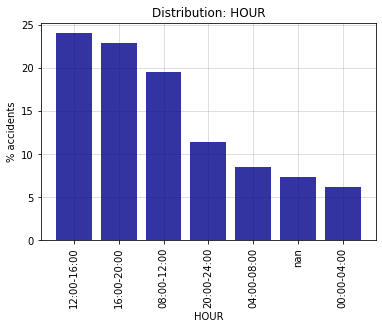

SPD_LIM,%
50,34.794698
NaN,30.487505
<50,17.832946
70,11.072383
100,4.772874
60,0.608803
80,0.338580
90,0.092211


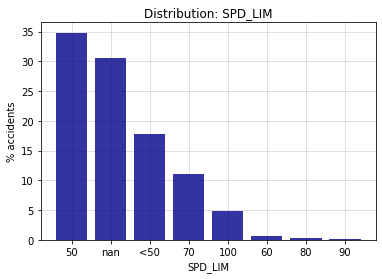

ACCDN_TYPE,%
veh,76.103945
fxd obj,9.110685
ped,4.383738
NaN,4.118143
cyc,2.834317
no coll,2.022579
oth,1.426593


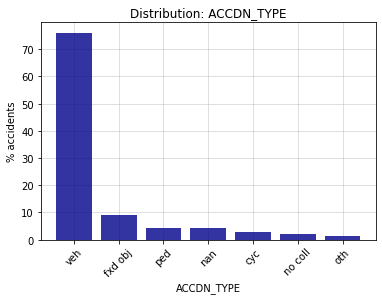

RD_COND,%
Dry,63.237907
Wet,16.747069
Snowy,8.789194
NaN,5.314744
Frozen,2.692619
Slush/sleet,1.504206
Hard snow,0.998651
Other,0.306538
Water acc,0.245657
Sand/gravel,0.118912


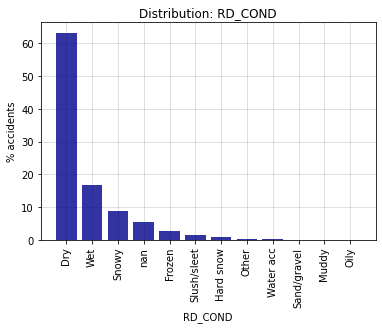

LIGHT,%
Clear day,63.389217
Lit path,25.661584
NaN,5.482788
Dawn/dusk,4.915284
Unlit path,0.551127


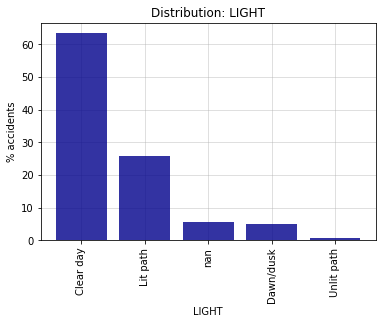

ZONE,%
Business/commercial,50.727537
Residential,34.387405
Industrial,6.405961
NaN,3.065377
Rural,2.226938
School,1.692544
Other,1.463264
Forest,0.030974


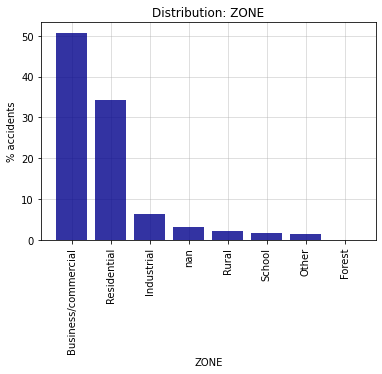

PUB_PRIV_RD,%
Public,85.321081
Private,11.767345
NaN,2.911574


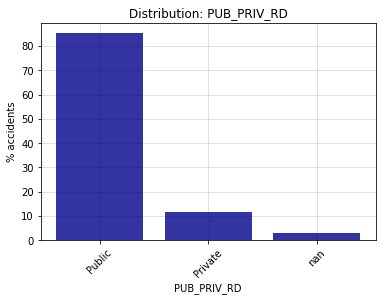

ASPECT,%
Straight,91.614895
NaN,4.265894
Curve,4.119211


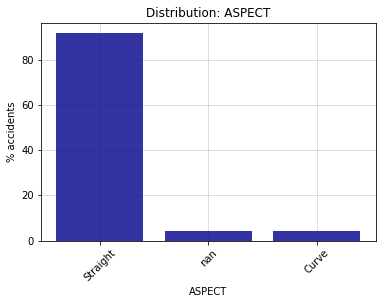

LONG_LOC,%
Int'n/roundabout,32.183609
Btwn int'ns,24.714913
Near int'n/roundabout,18.152656
Other,9.573517
NaN,7.880974
Shop centre,4.666778
Bridge etc.,2.827552


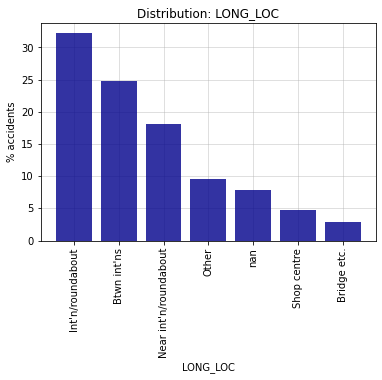

RD_CONFG,%
Two-way,43.338235
One-way,27.465919
Sep by layout,15.147092
NaN,9.106056
Other,4.942698


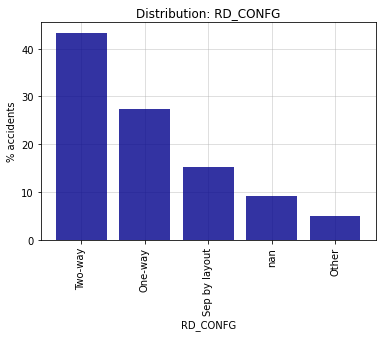

RDWX,%
NaN,96.492084
Y,3.507916


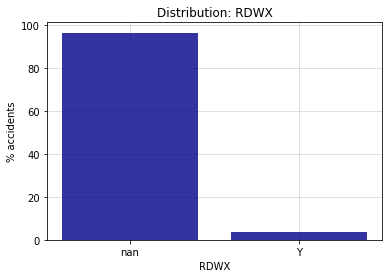

WEATHER,%
Clear,63.751651
Overcast,15.513086
Rain/drizzle,7.092022
NaN,5.672193
Snow/hail,5.354619
Blowing snow/snowstorm,0.845916
Downpour,0.617704
Other,0.484906
Black ice,0.330035
Strong wind,0.185845


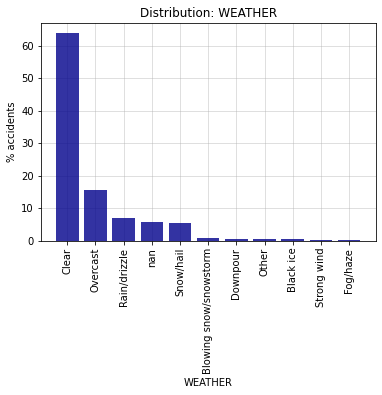

COLUMNS WITH NO NULL VALUES


YEAR,%
2011,12.244062
2012,11.141452
2013,11.125075
2017,8.335974
2016,8.189291
2018,8.180035
2015,8.104201
2014,8.008075
2019,7.552362
2022,6.224744


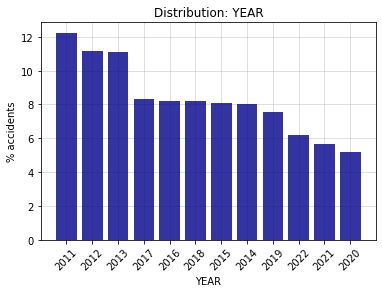

MONTH,%
Jan,9.528302
Feb,8.850786
Oct,8.684166
Dec,8.526803
Nov,8.522531
Jun,8.511138
Sep,8.473400
May,8.100641
Aug,8.068243
Jul,8.014127


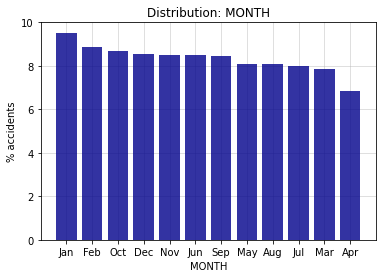

WKDY_WKND,%
WKDY,76.46175
WKND,23.53825


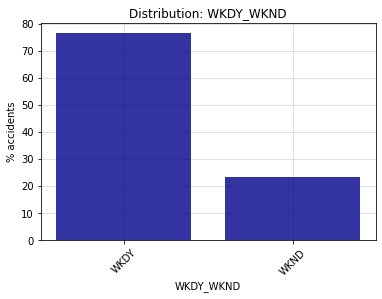

SEVERITY,%
Mat,43.538321
Mat < 2000,36.257250
Minor,19.343205
Fatal/serious,0.861225


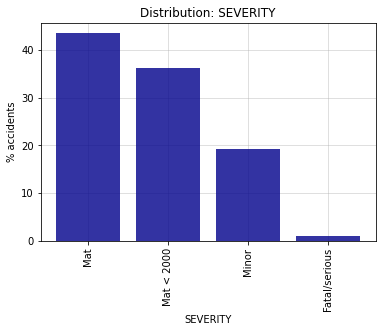

NUM_VICTIMS,%
0,79.795570
1,16.517077
2,2.770944
3+,0.916409


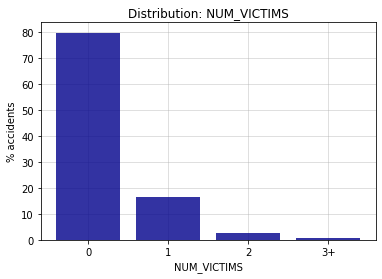

NUM_VEH,%
2,74.291777
1,16.316635
3+,9.391589


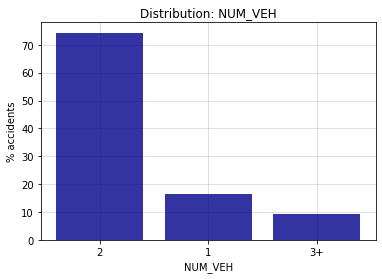

LT_TRK,%
Y,93.312779
N,6.687221


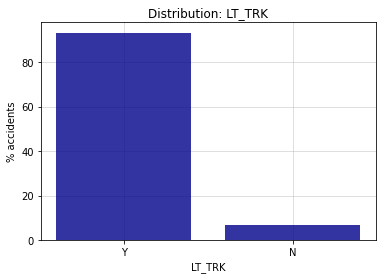

HVY_VEH,%
N,84.504716
Y,15.495284


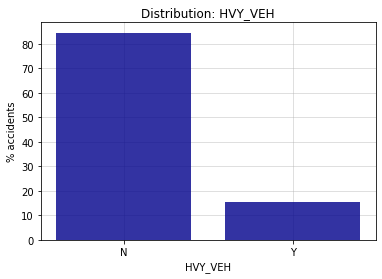

MTRCYC,%
N,98.221654
Y,1.778346


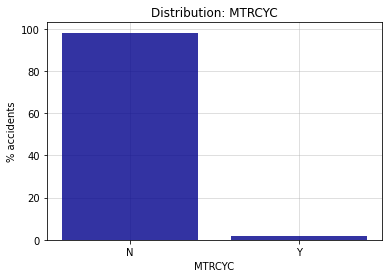

BICYC,%
N,96.889408
Y,3.110592


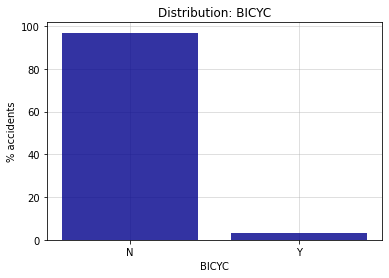

PED,%
N,96.041356
Y,3.958644


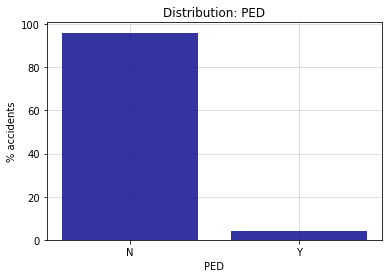

In [12]:
from exploration import distribution
from utils import get_variable_name

instance = mtl_sev
df = instance.df_train

columns = [c for c in df if c not in ["ID"] + list(instance.restrict_to.keys())]
columns_with_nulls = df.columns[df.isnull().any()].tolist()
columns_without_nulls = [c for c in columns if c not in columns_with_nulls]

print("="*24 + "\nColumns with null values\n".upper() + "="*24)

for col in columns_with_nulls:
    distribution.table(df, col);
    filename = "_".join([get_variable_name(instance), "EDA", "bar", col]) + ".png"
    filepath = path["expository"].joinpath(filename)
    distribution.plot(df, col, save_as=filepath)
    
print("="*27 + "\nColumns with no null values\n".upper() + "="*27)

for col in columns_without_nulls:
    distribution.table(df, col);
    filename = "_".join([get_variable_name(instance), "EDA", "bar", col]) + ".png"
    filepath = path["expository"].joinpath(filename)
    distribution.plot(df, col, save_as=filepath)

SEVERITY,%
Mat,43.538321
Mat < 2000,36.257250
Minor,19.343205
Fatal/serious,0.861225


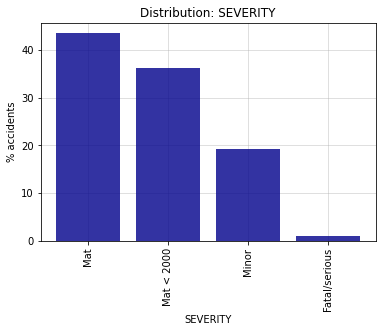

"(SEVERITY, NUM_VICTIMS)",%
"(Mat, 0)",43.538321
"(Mat < 2000, 0)",36.257250
"(Minor, 1)",15.853090
"(Minor, 2)",2.641351
"(Minor, 3+)",0.848764
"(Fatal/serious, 1)",0.663987
"(Fatal/serious, 2)",0.129593
"(Fatal/serious, 3+)",0.067645


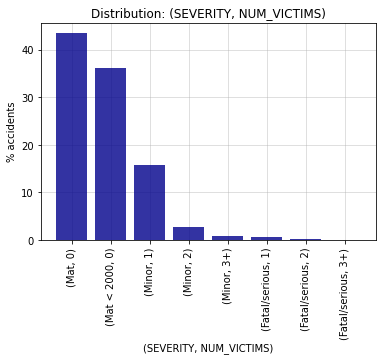

In [13]:
instance = mtl_sev
df = instance.df_train

for target in instance.targets:
    distribution.table(df, target);
    filename = "_".join([get_variable_name(instance), "EDA", "bar", target]) + ".png"
    filepath = path["expository"].joinpath(filename)
    distribution.plot(df, target, save_as=filepath)

distribution.tuple_table(df, instance.targets + ["NUM_VICTIMS"]);
filename = "_".join([get_variable_name(instance), "EDA", "bar", "SEVERITY_NUM_VICTIMS"]) + ".png"
filepath = path["expository"].joinpath(filename)
distribution.tuple_plot(df, instance.targets + ["NUM_VICTIMS"], save_as=filepath)

In [14]:
from variables import class_codes
from saaq_data_dictionary import shorthand

instance = mtl_sev
df = instance.df_train

variable_pairs = zip(["SEVERITY",
                       "PED", 
                       "BICYC", 
                       "PED",
                       "BICYC",
                       "NUM_VEH"],
                     ["NUM_VICTIMS",
                      "NUM_VICTIMS", 
                      "NUM_VICTIMS", 
                      "ACCDN_TYPE", 
                      "ACCDN_TYPE", 
                      "ACCDN_TYPE"])

for v1, v2 in variable_pairs:
    crosstab = pd.crosstab(df[v1], df[v2], dropna=False, margins=False)
    if v1 == "SEVERITY":
        order = class_codes["SEVERITY"].keys()
        crosstab = crosstab.loc[order]
    try:        
        crosstab.index = crosstab.index.map(shorthand[v1])
    except:
        pass
    try:
        crosstab.columns = crosstab.columns.map(shorthand[v2])
    except:
        pass
    display(crosstab)

NUM_VICTIMS,0,1,2,3+
SEVERITY,,,,
Mat < 2000,101839,0,0,0
Mat,122290,0,0,0
Minor,0,44528,7419,2384
Fatal/serious,0,1865,364,190


NUM_VICTIMS,0,1,2,3+
PED,,,,
N,224129,35905,7249,2477
Y,0,10488,534,97


NUM_VICTIMS,0,1,2,3+
BICYC,,,,
N,222036,39870,7676,2560
Y,2093,6523,107,14


ACCDN_TYPE,cyc,fxd obj,no coll,oth,ped,veh
PED,,,,,,
N,7955,25528,5648,3991,1784,213310
Y,6,62,33,16,10529,450


ACCDN_TYPE,cyc,fxd obj,no coll,oth,ped,veh
BICYC,,,,,,
N,155,25568,5586,3991,12305,213037
Y,7806,22,95,16,8,723


ACCDN_TYPE,cyc,fxd obj,no coll,oth,ped,veh
NUM_VEH,,,,,,
1,41,23192,4491,2690,11810,2210
2,7728,2156,926,1163,471,186547
3+,192,242,264,154,32,25003


In [15]:
from variables import saaq_variable_types

instance = mtl_sev
df = instance.df_train

ordinal_variables = [col for col in df.columns if saaq_variable_types[col] == "ordinal"]

# print("Ordinal variables:", ", ".join(ordinal_variables))

df_ordinal = df[ordinal_variables].copy()
for col in df_ordinal:
    df_ordinal[col] = df_ordinal[col].map(class_codes[col])

display(df_ordinal.corr())

,SEVERITY,NUM_VICTIMS,NUM_VEH,SPD_LIM,LIGHT
SEVERITY,1.000000,0.723654,-0.034036,0.073940,-0.033274
NUM_VICTIMS,0.723654,1.000000,-0.028884,-0.007636,0.002880
NUM_VEH,-0.034036,-0.028884,1.000000,0.010902,0.079634
SPD_LIM,0.073940,-0.007636,0.010902,1.000000,-0.006902
LIGHT,-0.033274,0.002880,0.079634,-0.006902,1.000000


In [16]:
instance = mtl_sev
df = instance.df_train

more_variable_pairs = [["SEVERITY", v] for v in ["ACCDN_TYPE",
                                                 "PED", 
                                                 "BICYC", 
                                                 "MTRCYC", 
                                                 "LT_TRK", 
                                                 "HVY_VEH",]]

for v1, v2 in more_variable_pairs:
    crosstab = pd.crosstab(df[v1], df[v2], 
                           dropna=False, margins=False, 
                           normalize="columns").mul(100).round(2)
    if v1 == "SEVERITY":
        order = class_codes["SEVERITY"].keys()
        crosstab = crosstab.loc[order]
        crosstab.index = crosstab.index.map(shorthand[v1])
    try:
        crosstab.columns = crosstab.columns.map(shorthand[v2])
    except:
        pass    
    display(crosstab)

ACCDN_TYPE,cyc,fxd obj,no coll,oth,ped,veh
SEVERITY,,,,,,
Mat < 2000,20.64,25.06,21.09,48.24,13.85,38.50
Mat,2.56,58.16,37.79,46.04,0.39,46.13
Minor,73.29,15.69,39.17,5.34,77.74,15.03
Fatal/serious,3.50,1.09,1.95,0.37,8.02,0.34


PED,N,Y
SEVERITY,,
Mat < 2000,37.75,0.00
Mat,45.33,0.00
Minor,16.41,90.55
Fatal/serious,0.51,9.45


BICYC,N,Y
SEVERITY,,
Mat < 2000,36.75,21.06
Mat,44.84,2.90
Minor,17.64,72.52
Fatal/serious,0.78,3.53


MTRCYC,N,Y
SEVERITY,,
Mat < 2000,36.44,26.25
Mat,44.06,14.71
Minor,18.71,54.15
Fatal/serious,0.79,4.88


LT_TRK,N,Y
SEVERITY,,
Mat < 2000,41.80,35.86
Mat,31.29,44.42
Minor,24.70,18.96
Fatal/serious,2.21,0.76


HVY_VEH,N,Y
SEVERITY,,
Mat < 2000,36.90,32.78
Mat,41.71,53.53
Minor,20.54,12.82
Fatal/serious,0.86,0.87


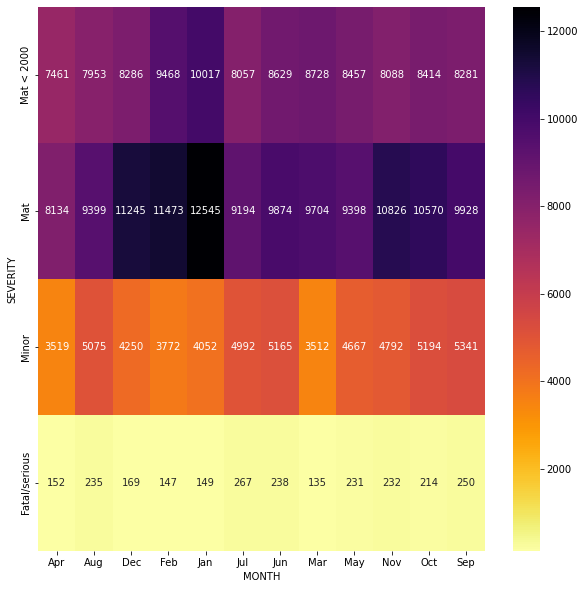

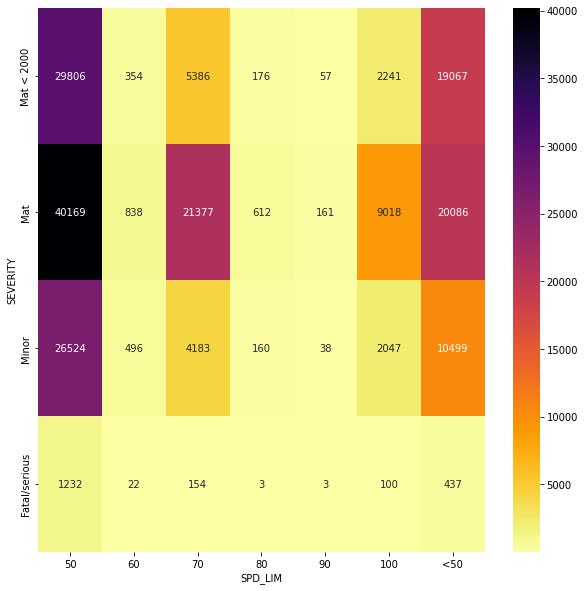

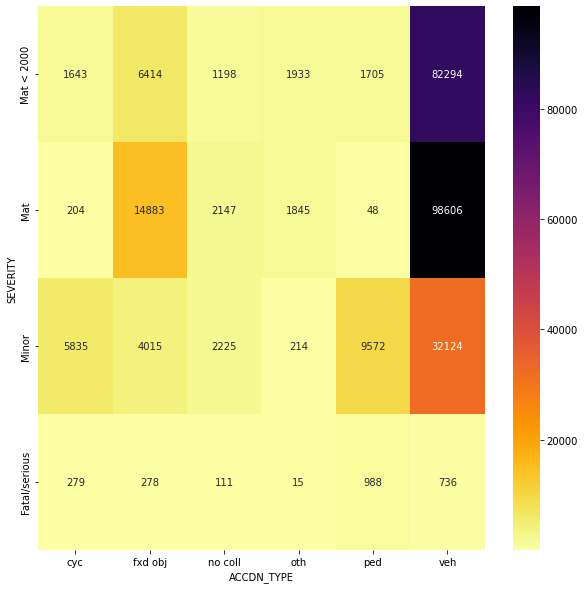

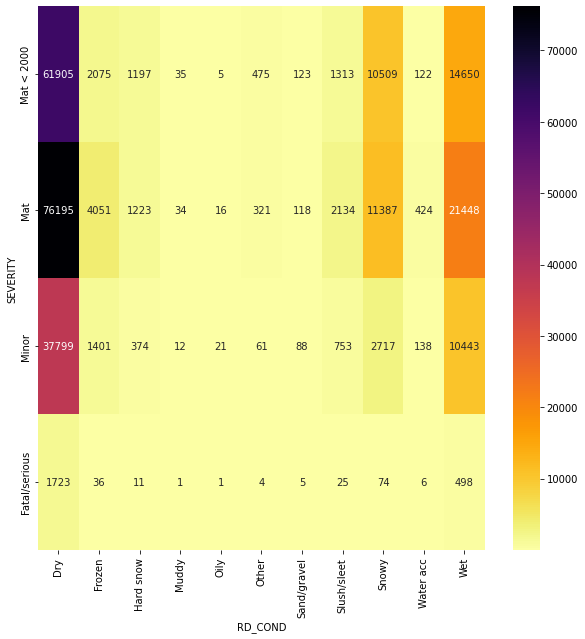

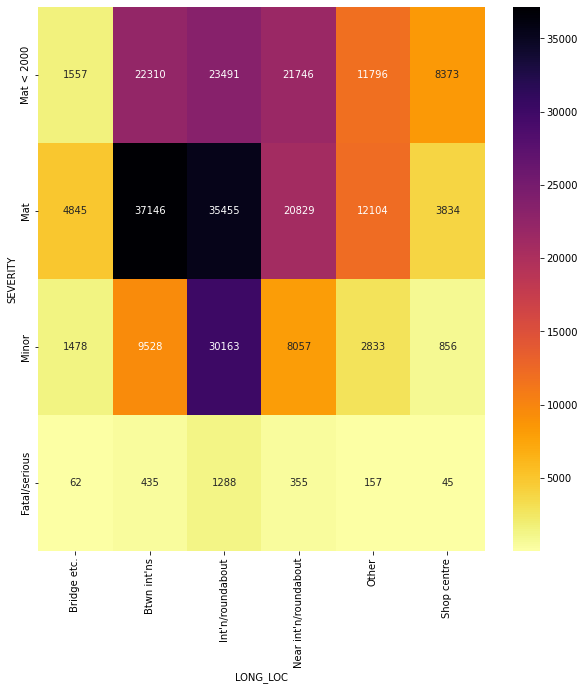

In [18]:
from matplotlib import pyplot as plt
import seaborn as sns

instance = mtl_sev
df = instance.df_train.copy()

for col in df.columns:
    try:
        df[col] = df[col].map(shorthand[col])
    except:
        pass

columns = [c for c in df.columns if c not in instance.targets]
columns.remove("ID")

# i columns[i]
# 0 'YEAR'
# 1 'MONTH'
# 2 'HOUR'
# 3 'WKDY_WKND'
# 4 'NUM_VICTIMS'
# 5 'NUM_VEH'
# 6 'REGION'
# 7 'SPD_LIM'
# 8 'ACCDN_TYPE'
# 9 'RD_COND'
# 10 'LIGHT'
# 11 'ZONE'
# 12 'PUB_PRIV_RD'
# 13 'ASPECT'
# 14 'LONG_LOC'
# 15 'RD_CONFG'
# 16 'RDWX'
# 17 'WEATHER'
# 18 'LT_TRK'
# 19 'HVY_VEH'
# 20 'MTRCYC'
# 21 'BICYC'
# 22 'PED'

for A in instance.targets:
    for idx in [1,7,8,9,14]:
        B = columns[idx]  
        AxB = pd.crosstab(df[A], df[B], dropna=True, margins=False)
        try:
            order = shorthand[A].values()
            AxB = AxB.loc[order]
        except:
            pass
        plt.figure(figsize=(10, 10))
        sns.heatmap(AxB, cmap='inferno_r', annot=True, fmt='d')
        filename = "_".join([get_variable_name(instance), "EDA", "heatmap", f"{A}", "by", f"{B}"]) + ".png"                
        filepath = path["expository"].joinpath(filename)
        plt.savefig(filepath)       

In [19]:
plt.close('all') 

SEVERITY BY YEAR: Prob(SEVERITY | YEAR = column heading)


YEAR,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,All
Mat < 2000,15006 (↓43.63%),14139 (↓45.18%),14227 (↓45.53%),7884 (↓35.05%),7839 (↓34.44%),7581 (↓32.96%),7980 (↓34.08%),7672 (↓33.39%),6685 (↓31.51%),4217 (↓28.8%),4196 (↓26.29%),4413 (↓25.24%),101839 (↓36.26%)
Mat,13755 (↓40.0%),11902 (↓38.03%),12042 (↓38.54%),9731 (↓43.26%),9850 (↓43.27%),10251 (↓44.57%),10458 (↓44.67%),10516 (↓45.77%),9960 (↓46.95%),7330 (↓50.06%),7725 (↓48.41%),8770 (↓50.16%),122290 (↓43.54%)
Minor,5350 (↓15.56%),4993 (↓15.96%),4750 (↓15.2%),4641 (↓20.63%),4842 (↓21.27%),4969 (↓21.6%),4783 (↓20.43%),4603 (↓20.03%),4415 (↓20.81%),2937 (↓20.06%),3910 (↓24.5%),4138 (↓23.67%),54331 (↓19.34%)
Fatal/serious,280 (↓0.81%),260 (↓0.83%),229 (↓0.73%),237 (↓1.05%),232 (↓1.02%),201 (↓0.87%),193 (↓0.82%),185 (↓0.81%),153 (↓0.72%),158 (↓1.08%),128 (↓0.8%),163 (↓0.93%),2419 (↓0.86%)
All,34391 (↓100.0%),31294 (↓100.0%),31248 (↓100.0%),22493 (↓100.0%),22763 (↓100.0%),23002 (↓100.0%),23414 (↓100.0%),22976 (↓100.0%),21213 (↓100.0%),14642 (↓100.0%),15959 (↓100.0%),17484 (↓100.0%),280879 (↓100.0%)


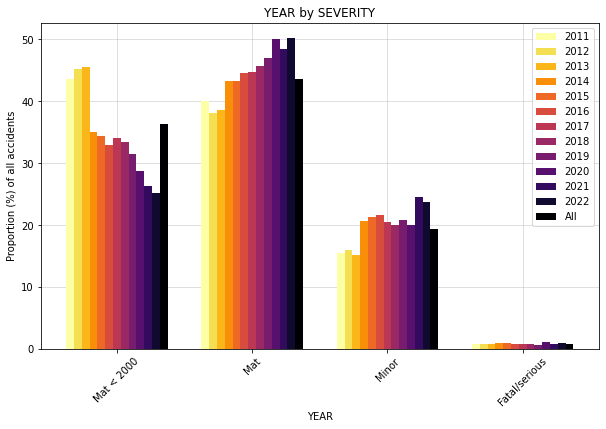

SEVERITY BY MONTH: Prob(SEVERITY | MONTH = column heading)


MONTH,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,All
Mat < 2000,7461 (↓38.73%),7953 (↓35.09%),8286 (↓34.6%),9468 (↓38.09%),10017 (↓37.43%),8057 (↓35.79%),8629 (↓36.1%),8728 (↓39.53%),8457 (↓37.17%),8088 (↓33.79%),8414 (↓34.49%),8281 (↓34.79%),101839 (↓36.26%)
Mat,8134 (↓42.22%),9399 (↓41.47%),11245 (↓46.95%),11473 (↓46.15%),12545 (↓46.87%),9194 (↓40.84%),9874 (↓41.3%),9704 (↓43.95%),9398 (↓41.3%),10826 (↓45.23%),10570 (↓43.33%),9928 (↓41.71%),122290 (↓43.54%)
Minor,3519 (↓18.27%),5075 (↓22.39%),4250 (↓17.75%),3772 (↓15.17%),4052 (↓15.14%),4992 (↓22.18%),5165 (↓21.61%),3512 (↓15.91%),4667 (↓20.51%),4792 (↓20.02%),5194 (↓21.29%),5341 (↓22.44%),54331 (↓19.34%)
Fatal/serious,152 (↓0.79%),235 (↓1.04%),169 (↓0.71%),147 (↓0.59%),149 (↓0.56%),267 (↓1.19%),238 (↓1.0%),135 (↓0.61%),231 (↓1.02%),232 (↓0.97%),214 (↓0.88%),250 (↓1.05%),2419 (↓0.86%)
All,19266 (↓100.0%),22662 (↓100.0%),23950 (↓100.0%),24860 (↓100.0%),26763 (↓100.0%),22510 (↓100.0%),23906 (↓100.0%),22079 (↓100.0%),22753 (↓100.0%),23938 (↓100.0%),24392 (↓100.0%),23800 (↓100.0%),280879 (↓100.0%)


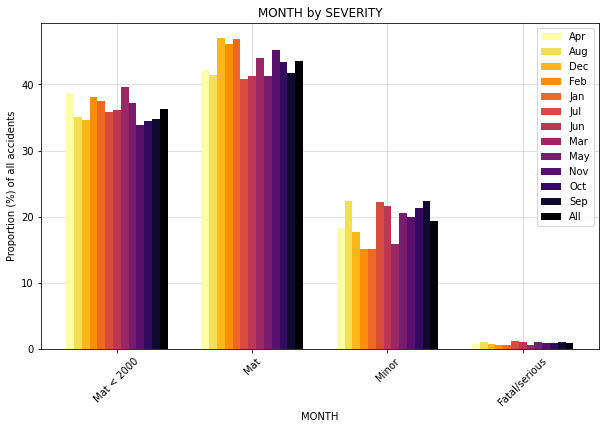

SEVERITY BY HOUR: Prob(SEVERITY | HOUR = column heading)


HOUR,00:00-04:00,04:00-08:00,08:00-12:00,12:00-16:00,16:00-20:00,20:00-24:00,All
Mat < 2000,4659 (↓26.62%),6373 (↓26.81%),20118 (↓36.61%),24548 (↓36.34%),22640 (↓35.17%),10394 (↓32.32%),88732 (↓34.09%)
Mat,9609 (↓54.9%),12190 (↓51.27%),23817 (↓43.34%),28429 (↓42.09%),26582 (↓41.29%),14969 (↓46.55%),115596 (↓44.41%)
Minor,2925 (↓16.71%),4951 (↓20.82%),10658 (↓19.39%),14083 (↓20.85%),14623 (↓22.71%),6370 (↓19.81%),53610 (↓20.59%)
Fatal/serious,310 (↓1.77%),261 (↓1.1%),365 (↓0.66%),484 (↓0.72%),531 (↓0.82%),422 (↓1.31%),2373 (↓0.91%)
All,17503 (↓100.0%),23775 (↓100.0%),54958 (↓100.0%),67544 (↓100.0%),64376 (↓100.0%),32155 (↓100.0%),260311 (↓100.0%)


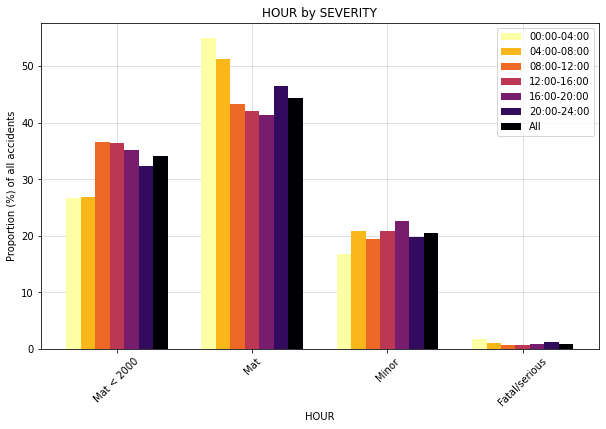

SEVERITY BY WKDY_WKND: Prob(SEVERITY | WKDY_WKND = column heading)


WKDY_WKND,WKDY,WKND,All
Mat < 2000,79213 (↓36.88%),22626 (↓34.22%),101839 (↓36.26%)
Mat,92004 (↓42.84%),30286 (↓45.81%),122290 (↓43.54%)
Minor,41805 (↓19.47%),12526 (↓18.95%),54331 (↓19.34%)
Fatal/serious,1743 (↓0.81%),676 (↓1.02%),2419 (↓0.86%)
All,214765 (↓100.0%),66114 (↓100.0%),280879 (↓100.0%)


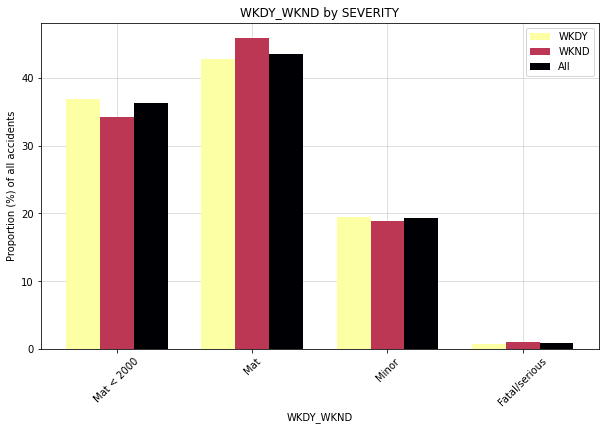

SEVERITY BY NUM_VICTIMS: Prob(SEVERITY | NUM_VICTIMS = column heading)


NUM_VICTIMS,0,1,2,3+,All
Mat < 2000,101839 (↓45.44%),0 (↓0.0%),0 (↓0.0%),0 (↓0.0%),101839 (↓36.26%)
Mat,122290 (↓54.56%),0 (↓0.0%),0 (↓0.0%),0 (↓0.0%),122290 (↓43.54%)
Minor,0 (↓0.0%),44528 (↓95.98%),7419 (↓95.32%),2384 (↓92.62%),54331 (↓19.34%)
Fatal/serious,0 (↓0.0%),1865 (↓4.02%),364 (↓4.68%),190 (↓7.38%),2419 (↓0.86%)
All,224129 (↓100.0%),46393 (↓100.0%),7783 (↓100.0%),2574 (↓100.0%),280879 (↓100.0%)


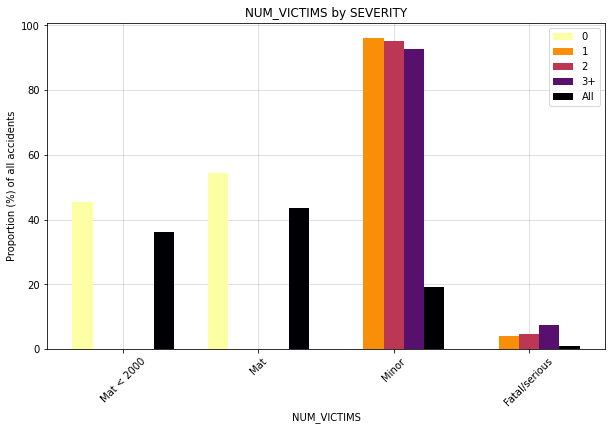

SEVERITY BY NUM_VEH: Prob(SEVERITY | NUM_VEH = column heading)


NUM_VEH,1,2,3+,All
Mat < 2000,11125 (↓24.27%),89140 (↓42.72%),1574 (↓5.97%),101839 (↓36.26%)
Mat,18110 (↓39.52%),86799 (↓41.6%),17381 (↓65.89%),122290 (↓43.54%)
Minor,15308 (↓33.4%),31844 (↓15.26%),7179 (↓27.21%),54331 (↓19.34%)
Fatal/serious,1287 (↓2.81%),887 (↓0.43%),245 (↓0.93%),2419 (↓0.86%)
All,45830 (↓100.0%),208670 (↓100.0%),26379 (↓100.0%),280879 (↓100.0%)


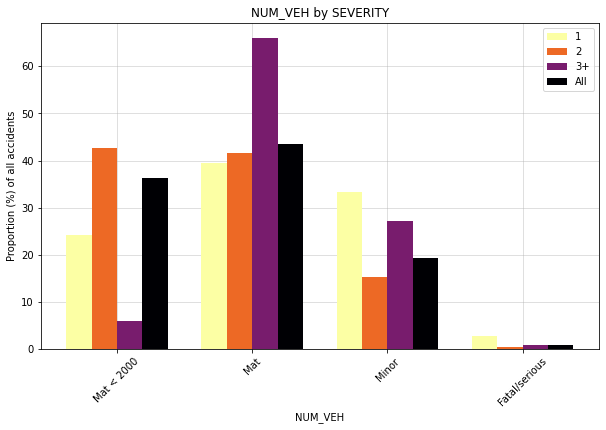

SEVERITY BY REGION: Prob(SEVERITY | REGION = column heading)


REGION,Montréal,All
Mat < 2000,101839 (↓36.26%),101839 (↓36.26%)
Mat,122290 (↓43.54%),122290 (↓43.54%)
Minor,54331 (↓19.34%),54331 (↓19.34%)
Fatal/serious,2419 (↓0.86%),2419 (↓0.86%)
All,280879 (↓100.0%),280879 (↓100.0%)


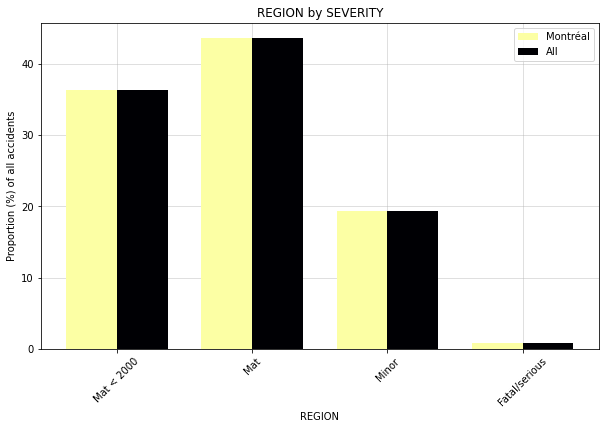

SEVERITY BY SPD_LIM: Prob(SEVERITY | SPD_LIM = column heading)


SPD_LIM,50,60,70,80,90,100,<50,All
Mat < 2000,29806 (↓30.5%),354 (↓20.7%),5386 (↓17.32%),176 (↓18.51%),57 (↓22.01%),2241 (↓16.72%),19067 (↓38.07%),57087 (↓29.24%)
Mat,40169 (↓41.1%),838 (↓49.01%),21377 (↓68.74%),612 (↓64.35%),161 (↓62.16%),9018 (↓67.27%),20086 (↓40.1%),92261 (↓47.25%)
Minor,26524 (↓27.14%),496 (↓29.01%),4183 (↓13.45%),160 (↓16.82%),38 (↓14.67%),2047 (↓15.27%),10499 (↓20.96%),43947 (↓22.51%)
Fatal/serious,1232 (↓1.26%),22 (↓1.29%),154 (↓0.5%),3 (↓0.32%),3 (↓1.16%),100 (↓0.75%),437 (↓0.87%),1951 (↓1.0%)
All,97731 (↓100.0%),1710 (↓100.0%),31100 (↓100.0%),951 (↓100.0%),259 (↓100.0%),13406 (↓100.0%),50089 (↓100.0%),195246 (↓100.0%)


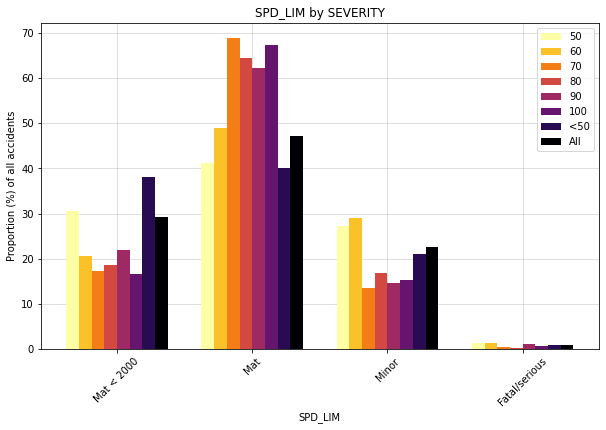

SEVERITY BY ACCDN_TYPE: Prob(SEVERITY | ACCDN_TYPE = column heading)


ACCDN_TYPE,cyc,fxd obj,no coll,oth,ped,veh,All
Mat < 2000,1643 (↓20.64%),6414 (↓25.06%),1198 (↓21.09%),1933 (↓48.24%),1705 (↓13.85%),82294 (↓38.5%),95187 (↓35.34%)
Mat,204 (↓2.56%),14883 (↓58.16%),2147 (↓37.79%),1845 (↓46.04%),48 (↓0.39%),98606 (↓46.13%),117733 (↓43.72%)
Minor,5835 (↓73.29%),4015 (↓15.69%),2225 (↓39.17%),214 (↓5.34%),9572 (↓77.74%),32124 (↓15.03%),53985 (↓20.05%)
Fatal/serious,279 (↓3.5%),278 (↓1.09%),111 (↓1.95%),15 (↓0.37%),988 (↓8.02%),736 (↓0.34%),2407 (↓0.89%)
All,7961 (↓100.0%),25590 (↓100.0%),5681 (↓100.0%),4007 (↓100.0%),12313 (↓100.0%),213760 (↓100.0%),269312 (↓100.0%)


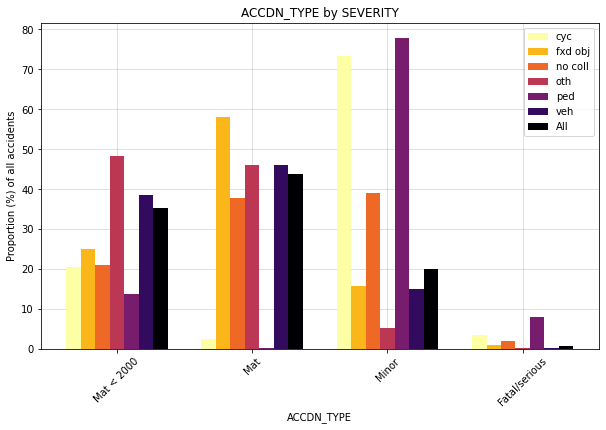

SEVERITY BY RD_COND: Prob(SEVERITY | RD_COND = column heading)


RD_COND,Dry,Frozen,Hard snow,Muddy,Oily,Other,Sand/gravel,Slush/sleet,Snowy,Water acc,Wet,All
Mat < 2000,61905 (↓34.85%),2075 (↓27.44%),1197 (↓42.67%),35 (↓42.68%),5 (↓11.63%),475 (↓55.17%),123 (↓36.83%),1313 (↓31.08%),10509 (↓42.57%),122 (↓17.68%),14650 (↓31.14%),92409 (↓34.75%)
Mat,76195 (↓42.9%),4051 (↓53.56%),1223 (↓43.6%),34 (↓41.46%),16 (↓37.21%),321 (↓37.28%),118 (↓35.33%),2134 (↓50.51%),11387 (↓46.13%),424 (↓61.45%),21448 (↓45.6%),117351 (↓44.13%)
Minor,37799 (↓21.28%),1401 (↓18.52%),374 (↓13.33%),12 (↓14.63%),21 (↓48.84%),61 (↓7.08%),88 (↓26.35%),753 (↓17.82%),2717 (↓11.01%),138 (↓20.0%),10443 (↓22.2%),53807 (↓20.23%)
Fatal/serious,1723 (↓0.97%),36 (↓0.48%),11 (↓0.39%),1 (↓1.22%),1 (↓2.33%),4 (↓0.46%),5 (↓1.5%),25 (↓0.59%),74 (↓0.3%),6 (↓0.87%),498 (↓1.06%),2384 (↓0.9%)
All,177622 (↓100.0%),7563 (↓100.0%),2805 (↓100.0%),82 (↓100.0%),43 (↓100.0%),861 (↓100.0%),334 (↓100.0%),4225 (↓100.0%),24687 (↓100.0%),690 (↓100.0%),47039 (↓100.0%),265951 (↓100.0%)


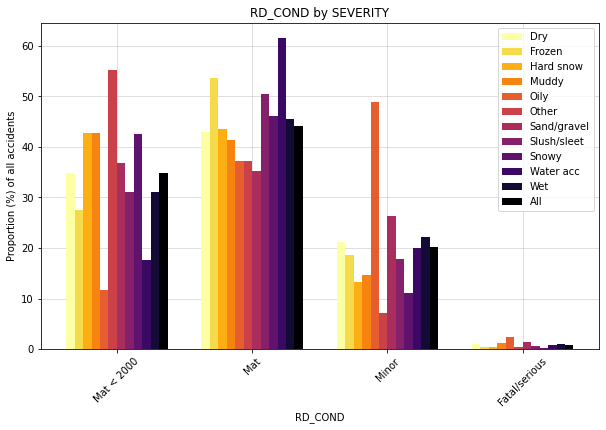

SEVERITY BY LIGHT: Prob(SEVERITY | LIGHT = column heading)


LIGHT,Clear day,Dawn/dusk,Lit path,Unlit path,All
Mat < 2000,64996 (↓36.5%),5086 (↓36.84%),21521 (↓29.86%),654 (↓42.25%),92257 (↓34.75%)
Mat,74728 (↓41.97%),5921 (↓42.89%),35651 (↓49.46%),619 (↓39.99%),116919 (↓44.04%)
Minor,37041 (↓20.8%),2667 (↓19.32%),13965 (↓19.37%),239 (↓15.44%),53912 (↓20.31%)
Fatal/serious,1282 (↓0.72%),132 (↓0.96%),941 (↓1.31%),36 (↓2.33%),2391 (↓0.9%)
All,178047 (↓100.0%),13806 (↓100.0%),72078 (↓100.0%),1548 (↓100.0%),265479 (↓100.0%)


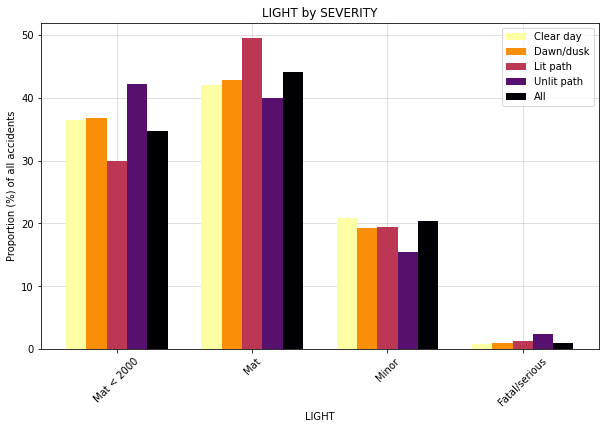

SEVERITY BY ZONE: Prob(SEVERITY | ZONE = column heading)


ZONE,Business/commercial,Forest,Industrial,Other,Residential,Rural,School,All
Mat < 2000,49957 (↓35.06%),19 (↓21.84%),4263 (↓23.69%),1805 (↓43.92%),37609 (↓38.94%),1572 (↓25.13%),1932 (↓40.64%),97157 (↓35.68%)
Mat,63516 (↓44.58%),48 (↓55.17%),10130 (↓56.3%),1482 (↓36.06%),38510 (↓39.87%),3654 (↓58.42%),1637 (↓34.43%),118977 (↓43.7%)
Minor,27793 (↓19.51%),17 (↓19.54%),3425 (↓19.04%),758 (↓18.44%),19634 (↓20.33%),981 (↓15.68%),1141 (↓24.0%),53749 (↓19.74%)
Fatal/serious,1217 (↓0.85%),3 (↓3.45%),175 (↓0.97%),65 (↓1.58%),834 (↓0.86%),48 (↓0.77%),44 (↓0.93%),2386 (↓0.88%)
All,142483 (↓100.0%),87 (↓100.0%),17993 (↓100.0%),4110 (↓100.0%),96587 (↓100.0%),6255 (↓100.0%),4754 (↓100.0%),272269 (↓100.0%)


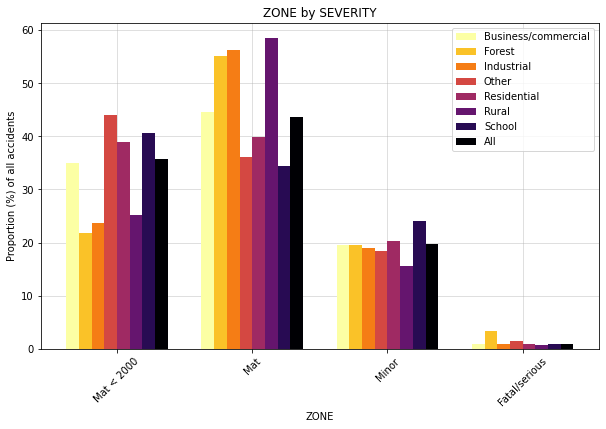

SEVERITY BY PUB_PRIV_RD: Prob(SEVERITY | PUB_PRIV_RD = column heading)


PUB_PRIV_RD,Private,Public,All
Mat < 2000,20851 (↓63.09%),76587 (↓31.96%),97438 (↓35.73%)
Mat,10196 (↓30.85%),108898 (↓45.44%),119094 (↓43.67%)
Minor,1882 (↓5.69%),51897 (↓21.66%),53779 (↓19.72%)
Fatal/serious,123 (↓0.37%),2267 (↓0.95%),2390 (↓0.88%)
All,33052 (↓100.0%),239649 (↓100.0%),272701 (↓100.0%)


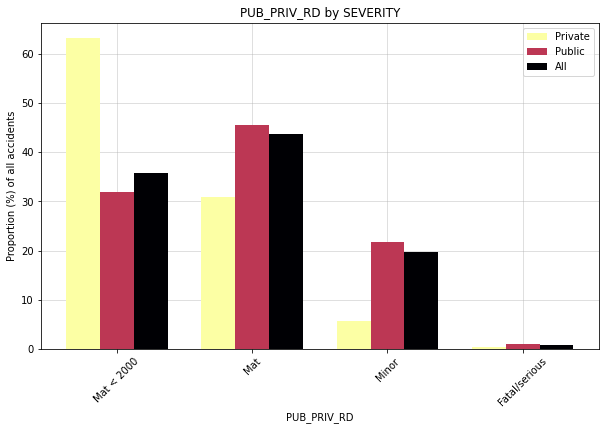

SEVERITY BY ASPECT: Prob(SEVERITY | ASPECT = column heading)


ASPECT,Curve,Straight,All
Mat < 2000,2417 (↓20.89%),91862 (↓35.7%),94279 (↓35.06%)
Mat,6874 (↓59.41%),111472 (↓43.32%),118346 (↓44.01%)
Minor,2132 (↓18.43%),51751 (↓20.11%),53883 (↓20.04%)
Fatal/serious,147 (↓1.27%),2242 (↓0.87%),2389 (↓0.89%)
All,11570 (↓100.0%),257327 (↓100.0%),268897 (↓100.0%)


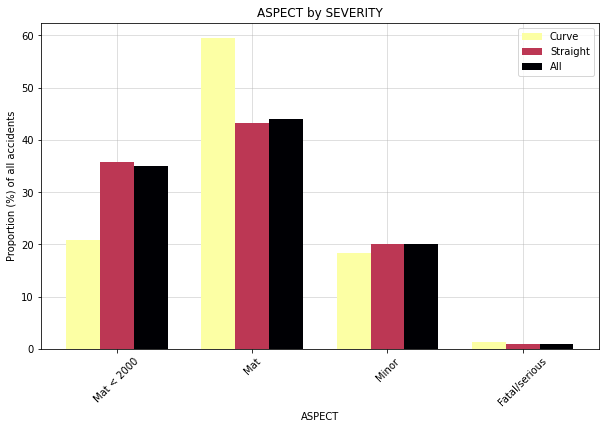

SEVERITY BY LONG_LOC: Prob(SEVERITY | LONG_LOC = column heading)


LONG_LOC,Bridge etc.,Btwn int'ns,Int'n/roundabout,Near int'n/roundabout,Other,Shop centre,All
Mat < 2000,1557 (↓19.6%),22310 (↓32.14%),23491 (↓25.99%),21746 (↓42.65%),11796 (↓43.87%),8373 (↓63.88%),89273 (↓34.5%)
Mat,4845 (↓61.0%),37146 (↓53.51%),35455 (↓39.22%),20829 (↓40.85%),12104 (↓45.01%),3834 (↓29.25%),114213 (↓44.14%)
Minor,1478 (↓18.61%),9528 (↓13.73%),30163 (↓33.37%),8057 (↓15.8%),2833 (↓10.54%),856 (↓6.53%),52915 (↓20.45%)
Fatal/serious,62 (↓0.78%),435 (↓0.63%),1288 (↓1.42%),355 (↓0.7%),157 (↓0.58%),45 (↓0.34%),2342 (↓0.91%)
All,7942 (↓100.0%),69419 (↓100.0%),90397 (↓100.0%),50987 (↓100.0%),26890 (↓100.0%),13108 (↓100.0%),258743 (↓100.0%)


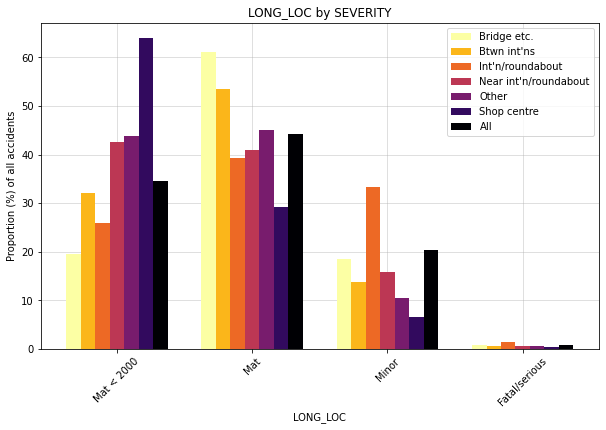

SEVERITY BY RD_CONFG: Prob(SEVERITY | RD_CONFG = column heading)


RD_CONFG,One-way,Other,Sep by layout,Two-way,All
Mat < 2000,28165 (↓36.51%),8045 (↓57.95%),9168 (↓21.55%),40246 (↓33.06%),85624 (↓33.54%)
Mat,36783 (↓47.68%),4727 (↓34.05%),24405 (↓57.36%),48405 (↓39.76%),114320 (↓44.78%)
Minor,11714 (↓15.18%),1038 (↓7.48%),8587 (↓20.18%),31675 (↓26.02%),53014 (↓20.77%)
Fatal/serious,484 (↓0.63%),73 (↓0.53%),385 (↓0.9%),1402 (↓1.15%),2344 (↓0.92%)
All,77146 (↓100.0%),13883 (↓100.0%),42545 (↓100.0%),121728 (↓100.0%),255302 (↓100.0%)


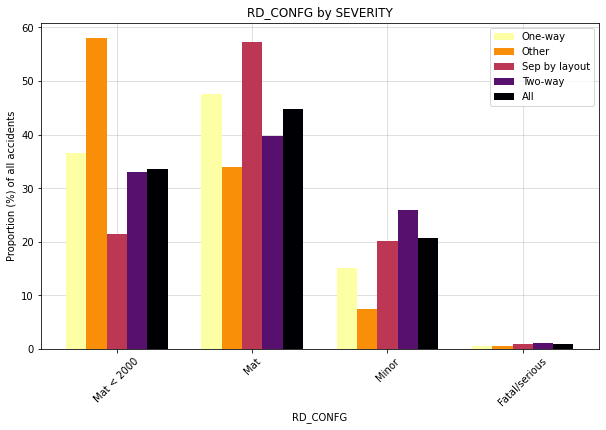

SEVERITY BY RDWX: Prob(SEVERITY | RDWX = column heading)


RDWX,Y,All
Mat < 2000,2584 (↓26.23%),2584 (↓26.23%)
Mat,5251 (↓53.29%),5251 (↓53.29%)
Minor,1932 (↓19.61%),1932 (↓19.61%)
Fatal/serious,86 (↓0.87%),86 (↓0.87%)
All,9853 (↓100.0%),9853 (↓100.0%)


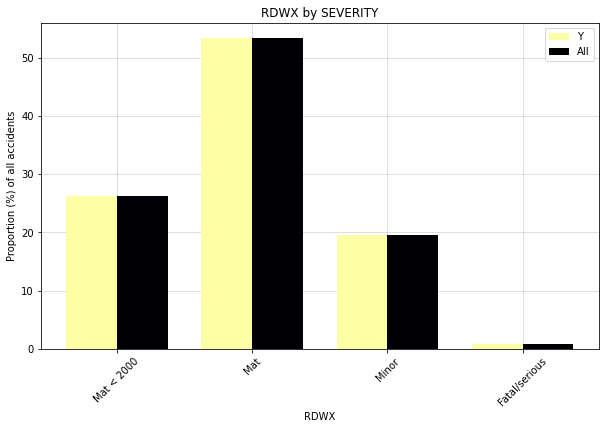

SEVERITY BY WEATHER: Prob(SEVERITY | WEATHER = column heading)


WEATHER,Black ice,Blowing snow/snowstorm,Clear,Downpour,Fog/haze,Other,Overcast,Rain/drizzle,Snow/hail,Strong wind,All
Mat < 2000,272 (↓29.34%),706 (↓29.71%),64268 (↓35.89%),407 (↓23.46%),136 (↓31.85%),826 (↓60.65%),14059 (↓32.27%),5820 (↓29.22%),5152 (↓34.26%),200 (↓38.31%),91846 (↓34.67%)
Mat,515 (↓55.56%),1321 (↓55.6%),75753 (↓42.3%),793 (↓45.71%),207 (↓48.48%),459 (↓33.7%),20919 (↓48.01%),9074 (↓45.55%),7682 (↓51.08%),221 (↓42.34%),116944 (↓44.14%)
Minor,139 (↓14.99%),334 (↓14.06%),37378 (↓20.87%),508 (↓29.28%),84 (↓19.67%),73 (↓5.36%),8221 (↓18.87%),4798 (↓24.09%),2146 (↓14.27%),92 (↓17.62%),53773 (↓20.3%)
Fatal/serious,1 (↓0.11%),15 (↓0.63%),1666 (↓0.93%),27 (↓1.56%),0 (↓0.0%),4 (↓0.29%),374 (↓0.86%),228 (↓1.14%),60 (↓0.4%),9 (↓1.72%),2384 (↓0.9%)
All,927 (↓100.0%),2376 (↓100.0%),179065 (↓100.0%),1735 (↓100.0%),427 (↓100.0%),1362 (↓100.0%),43573 (↓100.0%),19920 (↓100.0%),15040 (↓100.0%),522 (↓100.0%),264947 (↓100.0%)


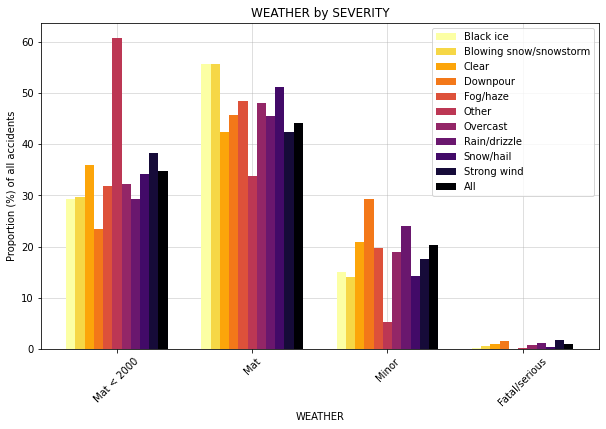

SEVERITY BY LT_TRK: Prob(SEVERITY | LT_TRK = column heading)


LT_TRK,N,Y,All
Mat < 2000,7851 (↓41.8%),93988 (↓35.86%),101839 (↓36.26%)
Mat,5878 (↓31.29%),116412 (↓44.42%),122290 (↓43.54%)
Minor,4639 (↓24.7%),49692 (↓18.96%),54331 (↓19.34%)
Fatal/serious,415 (↓2.21%),2004 (↓0.76%),2419 (↓0.86%)
All,18783 (↓100.0%),262096 (↓100.0%),280879 (↓100.0%)


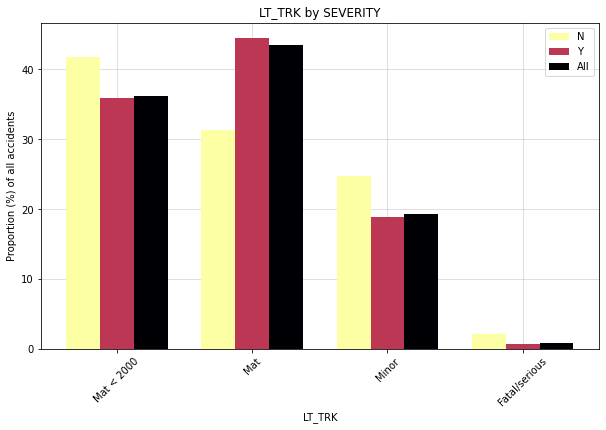

SEVERITY BY HVY_VEH: Prob(SEVERITY | HVY_VEH = column heading)


HVY_VEH,N,Y,All
Mat < 2000,87573 (↓36.9%),14266 (↓32.78%),101839 (↓36.26%)
Mat,98992 (↓41.71%),23298 (↓53.53%),122290 (↓43.54%)
Minor,48752 (↓20.54%),5579 (↓12.82%),54331 (↓19.34%)
Fatal/serious,2039 (↓0.86%),380 (↓0.87%),2419 (↓0.86%)
All,237356 (↓100.0%),43523 (↓100.0%),280879 (↓100.0%)


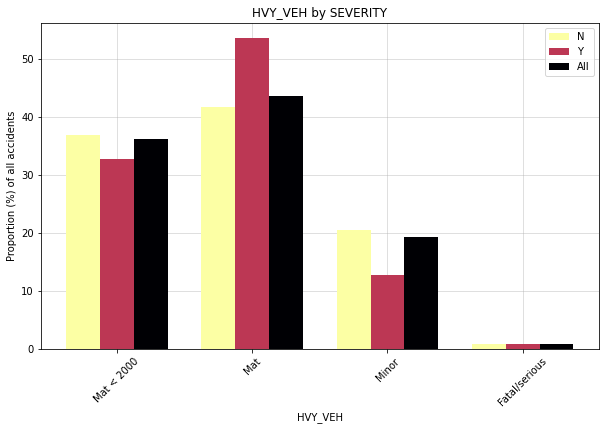

SEVERITY BY MTRCYC: Prob(SEVERITY | MTRCYC = column heading)


MTRCYC,N,Y,All
Mat < 2000,100528 (↓36.44%),1311 (↓26.25%),101839 (↓36.26%)
Mat,121555 (↓44.06%),735 (↓14.71%),122290 (↓43.54%)
Minor,51626 (↓18.71%),2705 (↓54.15%),54331 (↓19.34%)
Fatal/serious,2175 (↓0.79%),244 (↓4.88%),2419 (↓0.86%)
All,275884 (↓100.0%),4995 (↓100.0%),280879 (↓100.0%)


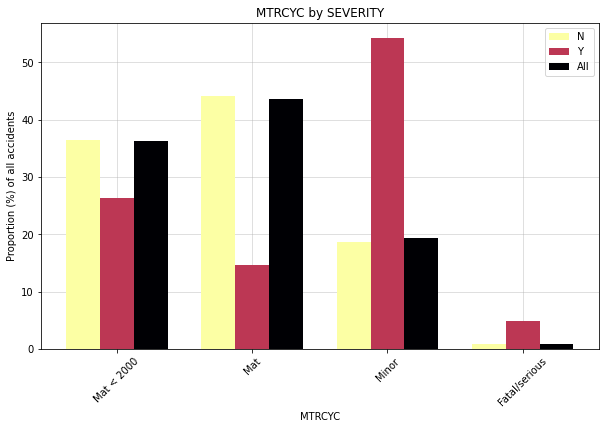

SEVERITY BY BICYC: Prob(SEVERITY | BICYC = column heading)


BICYC,N,Y,All
Mat < 2000,99999 (↓36.75%),1840 (↓21.06%),101839 (↓36.26%)
Mat,122037 (↓44.84%),253 (↓2.9%),122290 (↓43.54%)
Minor,47995 (↓17.64%),6336 (↓72.52%),54331 (↓19.34%)
Fatal/serious,2111 (↓0.78%),308 (↓3.53%),2419 (↓0.86%)
All,272142 (↓100.0%),8737 (↓100.0%),280879 (↓100.0%)


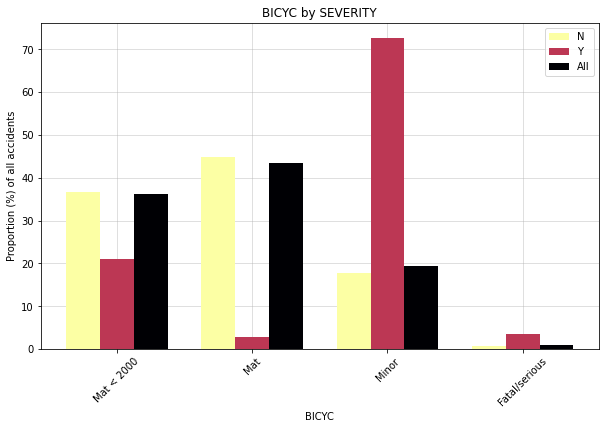

SEVERITY BY PED: Prob(SEVERITY | PED = column heading)


PED,N,Y,All
Mat < 2000,101839 (↓37.75%),0 (↓0.0%),101839 (↓36.26%)
Mat,122290 (↓45.33%),0 (↓0.0%),122290 (↓43.54%)
Minor,44263 (↓16.41%),10068 (↓90.55%),54331 (↓19.34%)
Fatal/serious,1368 (↓0.51%),1051 (↓9.45%),2419 (↓0.86%)
All,269760 (↓100.0%),11119 (↓100.0%),280879 (↓100.0%)


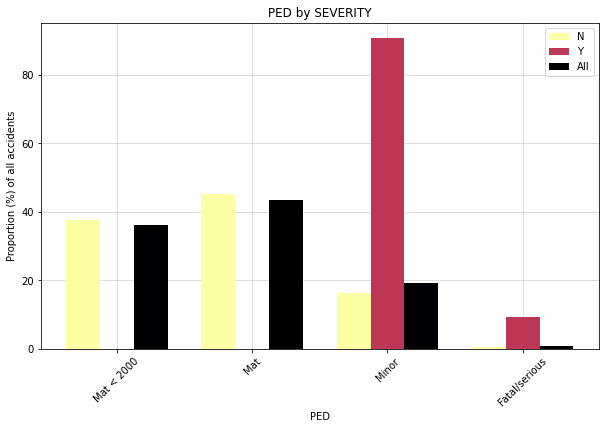

In [21]:
from saaq_data_dictionary import shorthand
from exploration import custom_crosstab, crosstab_plot

instance = mtl_sev
df = instance.df_train.copy()

for col in df.columns:
    try:
        df[col] = df[col].map(shorthand[col])
    except:
        pass

columns = [c for c in df.columns if c not in instance.targets]
columns.remove("ID")

for A in instance.targets:
    for B in columns:
        print(f"{A} by {B}:".upper(), f"Prob({A} | {B} = column heading)")
        _, AxB1, AxB2, _, _ = custom_crosstab(df[A], df[B])  
        try:
            order = list(shorthand[A].values())
            AxB1 = AxB1.loc[order]
            order = order + ['All']
            AxB2 = AxB2.loc[order]
        except:
            pass
        display(AxB2)
        filename = "_".join([get_variable_name(instance), "EDA", "bar", f"{A}", "by", f"{B}"]) + ".png"                
        filepath = path["expository"].joinpath(filename)
        crosstab_plot(AxB1,ylabel=f"Proportion (%) of all accidents",save_as=filepath)

In [22]:
plt.close('all')

ACCDN_TYPE,cyc,fxd obj,no coll,oth,ped,veh,All
Mat < 2000,1643 (↓20.64%),6414 (↓25.06%),1198 (↓21.09%),1933 (↓48.24%),1705 (↓13.85%),82294 (↓38.5%),95187 (↓35.34%)
Mat,204 (↓2.56%),14883 (↓58.16%),2147 (↓37.79%),1845 (↓46.04%),48 (↓0.39%),98606 (↓46.13%),117733 (↓43.72%)
Minor,5835 (↓73.29%),4015 (↓15.69%),2225 (↓39.17%),214 (↓5.34%),9572 (↓77.74%),32124 (↓15.03%),53985 (↓20.05%)
Fatal/serious,279 (↓3.5%),278 (↓1.09%),111 (↓1.95%),15 (↓0.37%),988 (↓8.02%),736 (↓0.34%),2407 (↓0.89%)
All,7961 (↓100.0%),25590 (↓100.0%),5681 (↓100.0%),4007 (↓100.0%),12313 (↓100.0%),213760 (↓100.0%),269312 (↓100.0%)


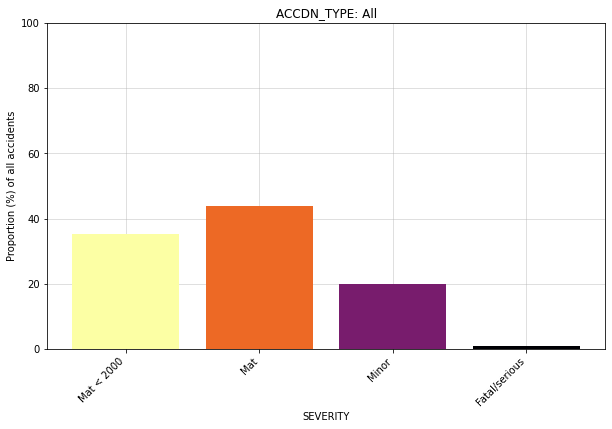

In [23]:
from saaq_data_dictionary import shorthand
from exploration import custom_crosstab, crosstab_animation
from IPython.display import HTML

instance = mtl_sev
df = instance.df_train.copy()

A = "SEVERITY"
BB = ["MONTH", "ACCDN_TYPE", "WEATHER", "RD_CONFG", "RD_COND", "LONG_LOC", "ASPECT", "SPD_LIM"]
B = BB[1]

try:
    df[A] = df[A].map(shorthand[A])
except:
    pass

try:
    df[B] = df[B].map(shorthand[B])
except:
    pass

filename = filename = "_".join([get_variable_name(instance), "EDA", "crosstab", f"{A}", "by", f"{B}"]) + ".txt"
filepath = path["expository"].joinpath(filename)
AxB = custom_crosstab(df[A], df[B], save_as=None)[1]
AxB2 = custom_crosstab(df[A], df[B])[2]

try:
    order = list(shorthand[A].values())
    AxB = AxB.loc[order]
    order2 = order + ['All']
    AxB2 = AxB2.loc[order2]
except:
    pass

display(AxB2)

filename = filename = "_".join([get_variable_name(instance), "EDA", "bar", "anim", f"{A}", "by", f"{B}"]) + ".gif"
filepath = path["expository"].joinpath(filename)
anim = crosstab_animation(AxB, "Proportion (%) of all accidents", save_as=filepath)
HTML(anim.to_jshtml())

![Alt Text](../expository/mtl_sev_EDA_bar_anim_SEVERITY_by_ACCDN_TYPE.gif)

![Alt Text](../expository/mtl_sev_EDA_bar_anim_SEVERITY_by_MONTH.gif)

![Alt Text](../expository/mtl_sev_EDA_bar_anim_SEVERITY_by_RD_CONFG.gif)

![Alt Text](../expository/mtl_sev_EDA_bar_anim_SEVERITY_by_RD_COND.gif)

![Alt Text](../expository/mtl_sev_EDA_bar_anim_SEVERITY_by_LONG_LOC.gif)

![Alt Text](../expository/mtl_sev_EDA_bar_anim_SEVERITY_by_ASPECT.gif)

![Alt Text](../expository/mtl_sev_EDA_bar_anim_SEVERITY_by_SPD_LIM.gif)